# Libraries

In [712]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
from itertools import chain

# Plotting Libs
import matplotlib.pyplot as plt 
import seaborn as sns

# Statistical libs
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler


# Load Dfs

In [713]:
df = pd.read_pickle(r".\df_data\df.pkl")
df1 = pd.read_pickle(r".\df_data\df1.pkl")
df2 = pd.read_pickle(r".\df_data\df2.pkl")
df3 = pd.read_pickle(r".\df_data\df3.pkl")
df4 = pd.read_pickle(r".\df_data\df4.pkl")
medians = pd.read_pickle(r".\df_data\medians.pkl")


# Df Input

In [714]:
i = 4
dfi = df4

In [715]:
dfis = [df1, df2, df3, df4]

# Functions

## chi2_fun

In [716]:
def chi2_fun(col, dfi, i):
    global p_value
    p_value = []
    
    df_plot = dfi[[col, "Study_Status_Bin"]].copy()  
    df_plot = df_plot.dropna(subset = [col])
    df_plot = df_plot.reset_index(drop = True)
    print(f"df{i}-Phase{i}:\n{col} vs Study Status\n")    

# Descriptives
    df_plot[col] = df_plot[col].astype('category')

    # display(pd.crosstab(df_plot[col], df_plot["Study_Status_Bin"])) # pivot in log_fun also
    # df_plot[col] = df_plot[col].astype('category') 
    stat = stats.chi2_contingency(pd.crosstab(df_plot[col], df_plot["Study_Status_Bin"]))
    
    pvalue = stat.pvalue
    p_value.append(pvalue)

# Test
    if pvalue < 0.05 :
        print(f'p-value: {pvalue} < 0.05\n')
    else:
        print(f'p-value: {pvalue} > 0.05 - No significant difference\n')
    print("------------------------------------------------------------------------------------------------------------\n")

    return p_value

## Logistic

In [717]:
from pandas import pivot


def log_fun(col, dfi, i, type, t, rot, drop_col = None):
    global aic_categ
    global p_value
    global cl
    aic_categ = []
    p_value = []

    print(f"df{i}-Phase{i}:\n{col} vs Study Status (Termination)\n")
    df_plot = dfi[['Study_Status_Bin', col]].copy()
    df_plot = df_plot.dropna(subset = [col]).reset_index(drop = True)  
    df_expl = df_plot.explode(col) # Do not reset index, needed for groupby
    df_expl[col] = pd.Categorical(df_expl[col], ordered = t)
    df_expl[col] = df_expl[col].cat.remove_unused_categories()

    # Pivot Table
    pivot = df_expl.pivot_table(
        index = [col], 
        columns = ["Study_Status_Bin"], 
        aggfunc = "size", 
        fill_value = 0, 
        observed = False)
    display(pivot)

    if (pivot <= 5).any().any():
        print("SPARSITY RISK\n")

    # Dummies - df_model      
    if type == 'list':    
        dummies = pd.get_dummies(df_expl[col] , drop_first = False, dtype = int , prefix = '' , prefix_sep = '', dummy_na = False)
        dummies.index = df_expl.index # ensure same index dummies - df_expl --> same index dummies.grouped - df_plot (= melted df_expl)
        dummies = dummies.groupby(dummies.index).sum()   # index needed for groupby comes from dummies not exploded df_plot
        df_model = pd.concat([df_plot.drop(columns = [col], axis = 1), dummies], axis=1)
        if drop_col != None:
            df_model = df_model.drop(columns = [drop_col], axis = 1)
    else:
        df_model = df_expl.copy()
        cats = sorted(dfi[col].dropna().unique())
        df_model[col] = df_model[col].map({cats[0]: 0, cats[1]: 1, 'No':0, 'Yes':1})
                
    # Model
    X = sm.add_constant(df_model.drop(columns = ["Study_Status_Bin"], axis = 1))
    y = (df_model["Study_Status_Bin"] == "TERMINATED").astype(int)

    model = sm.Logit(y, X)
    results = model.fit(method = 'lbfgs', maxiter = 500)
    print(results.summary())
    print("\n")

    # AIC
    aic = round(results.aic, 0)  # AIC test in case needed for comparison
    aic_categ.append(aic)
    pvalue = results.pvalues
    p_value.append(pvalue)
    cl = results.conf_int()
    
    print(f'df{i}-Phase{i}: {col} p-values:\n{p_value}\n')
    print(f'df{i}-Phase{i}: {col} AIC:\n{aic}')  
    print("\n------------------------------------------------------------------------------------------------------------\n")

    # df_plot
    df_plot = df_plot.explode(col).reset_index(drop = True)
    df_plot[col] = pd.Categorical(df_plot[col], ordered = t)
    df_plot[col] = df_plot[col].cat.remove_unused_categories()
    
    # Plot
    plt.figure(figsize = (10, 2))
    sns.countplot(data = df_plot, x = col, hue = 'Study_Status_Bin')
    plt.xticks(rotation = rot, fontsize = 8) 
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 2)
    plt.title(f"df{i}-Phase{i}: {col} vs Study Status")

    return aic_categ, p_value, cl

## Log_fun_cont

In [718]:
def log_fun_cont(col, dfi, i):
    global aic_cont
    global p_value
    global cl
    aic_cont = []
    p_value = []

    df_plot = dfi.dropna(subset = [col]).reset_index(drop = True) 
    df_plot_y = df_plot[["Study_Status_Bin"]].copy()
    df_plot_x = df_plot[[col]].copy()

# Dfi names
    print(f"df{i}-Phase{i}:\n{col} vs Study Status")
    print("\n")
    
# Descriptives
    print(df_plot[col].describe())
    print("\n")

# Scale
    scaler = StandardScaler()
    data_scaled_x = scaler.fit_transform(df_plot_x)
    df_scaled_x = pd.DataFrame(data_scaled_x)
    df_scaled = pd.concat([df_plot_y, df_scaled_x], axis=1)
    df_scaled.rename(columns={0: col}, inplace=True)

    X = sm.add_constant(df_scaled[col])
    y = (df_scaled["Study_Status_Bin"] == "TERMINATED").astype(int)

# Model
    model = sm.Logit(y, X)
    results = model.fit(method='lbfgs', maxiter = 500)
    print(results.summary())
    print("\n")

    # AIC
    aic = round(results.aic, 0)
    aic_cont.append(aic)
    pvalue = results.pvalues
    p_value.append(pvalue)
    cl = results.conf_int()
    
    print(f'df{i}-Phase{i}, {col} p-values:\n{p_value}\n')
    print(f'df{i}-Phase{i}, {col} AIC:\n{aic}')
    print("\n------------------------------------------------------------------------------------------------------------\n")

# Plot
    fig , ax = plt.subplots(figsize = (20, 4) , ncols = 2, nrows = 1, layout = 'tight')
    color = sns.color_palette("tab10", n_colors = 2)
    
    sns.boxplot(x = col, hue = "Study_Status_Bin", data = dfi, ax = ax[0] , legend = True) 
    sns.kdeplot(x = col, hue = "Study_Status_Bin", data = dfi, ax = ax[1] , legend = False) 

    ax[0].legend(bbox_to_anchor = (1.05, 1), loc = 2)
    
    return aic_cont, p_value, cl

# Medians

In [719]:
medians = pd.read_pickle(r".\df_data\medians.pkl")
medians

,Enrollment,Adverse,Adverse_System,Arm,Intervention_Type,Intervention_Route,City,Country,Continent,Completion_Gap
df1,28.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,14.0
df2,41.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,26.0
df3,158.0,0.0,0.0,2.0,1.0,1.0,2.0,1.0,1.0,24.0
df4,60.5,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,21.0
Mean,71.875,0.0,0.0,2.0,1.0,1.0,1.25,1.0,1.0,21.25
Median,50.75,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,22.5


In [720]:
# Columns for which distribution is more wide --> May be kept as Log
medians_categ = medians.loc[:, medians.loc["Median"] > 5]
categ_cols = medians_categ.columns.to_list()
drop_categ_cols = [col + "_Categ" for col in categ_cols]

# Columns with almost all distribution around lower values e.g., 0, 1 ,2 --> may be kept as categ.
medians_log = medians.loc[:, medians.loc["Median"] < 5]
drop_log_cols = [col for col in df1.columns 
                 if "_Log" in col and any(name in col for name in medians_log)]

display(drop_log_cols)

['Adverse_Counts_Log',
 'Adverse_System_Counts_Log',
 'Arm_Counts_Log',
 'Continent_Counts_Log',
 'City_Counts_Log']

# Visualization

## Phases_List
All df before Seperation into Phases

df-Phase:
Phases_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Phases_List,,
PHASE1,22546,4778
PHASE2,21703,7557
PHASE3,13556,2947
PHASE4,10937,2309


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                78301
Model:                          Logit   Df Residuals:                    78297
Method:                           MLE   Df Model:                            3
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                 0.01411
Time:                        05:28:38   Log-Likelihood:                -38351.
converged:                       True   LL-Null:                       -38900.
Covariance Type:            nonrobust   LLR p-value:                9.241e-238
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7141      0.018    -96.826      0.000      -1.749      -1.679
PHASE2         0.6530      0.021     30.724      0.000       0.611       0.695
PHASE3         0.0696      0.025      2.777      0.0

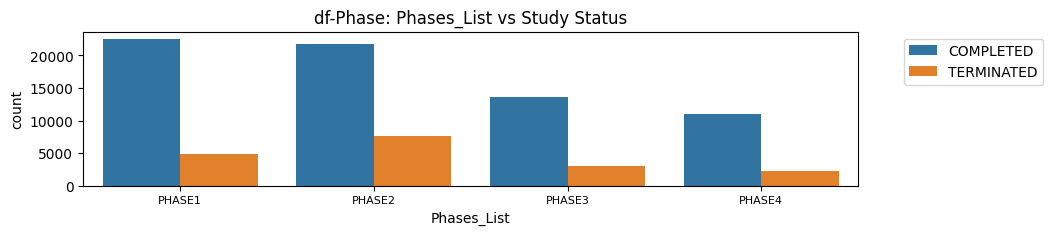

In [721]:
Phases_List = log_fun('Phases_List', df, '', 'list', False, 0, 'PHASE1')

## Adverse


### Adverse_List

df4-Phase4:
Adverse_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Adverse_List,,
Adv_Death,1585,235
Adv_None,7904,1846
Adv_Serious,1591,195
Adv_Unspecified,2466,350


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13242
Method:                           MLE   Df Model:                            3
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.006852
Time:                        05:28:38   Log-Likelihood:                -6086.5
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 4.292e-18
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.4522      0.025    -57.162      0.000      -1.502      -1.402
Adv_Death          -0.0798      0.086     -0.924      0.356      -0.249       0.090
Adv_Serious        -0.3639      

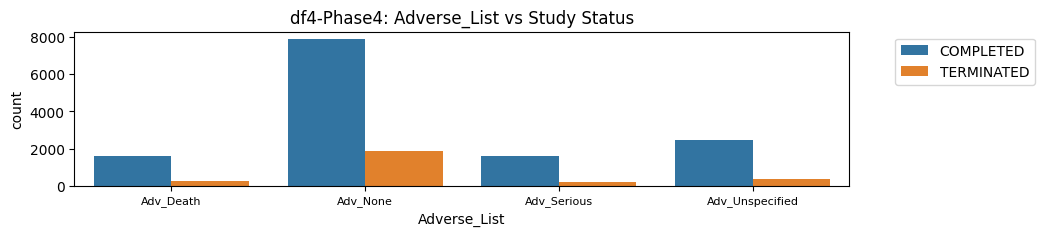

In [722]:
Adverse_List = log_fun("Adverse_List", dfi, i, 'list', False, 0, 'Adv_None')
# Adverse Death has p value >> 0.05 
# Death does not support adverse from the drug/intervention.
# Corresponds to event noticed in trial but may correspond to patients' state of health due to condition

### Adverse_Counts
Many unique points, in most of features values, are out of main distribution. --> Make pd.cut
log_fun('Adverse_Counts', dfi, i, 'bin', True, 0) --> Error for small values in some levels


df4-Phase4:
Adverse_Counts vs Study Status


count    13246.000000
mean        28.577004
std        652.944694
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      70245.000000
Name: Adverse_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                 0.01429
Time:                        05:28:39   Log-Likelihood:                -6040.9
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 5.552e-40
                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

C:\Users\Eugenia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Eugenia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


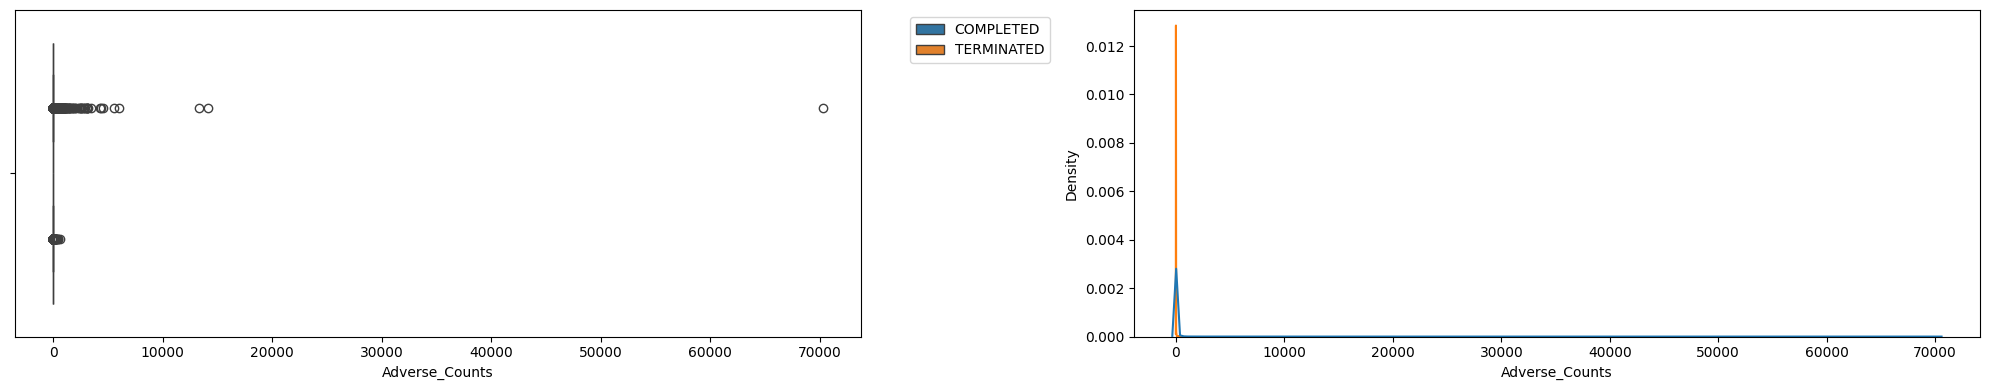

In [723]:
Adverse_Counts = log_fun_cont("Adverse_Counts", dfi, i)  

### Adverse_Counts_Log
- Adverse_Counts despite mostly have the ditribution around small values (0,1,2 etc.) they also have a wide range of values in the remaining distribution.
- That is why they were checked as Log too

df4-Phase4:
Adverse_Counts_Log vs Study Status


count    13246.000000
mean         0.711527
std          1.502002
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         11.159759
Name: Adverse_Counts_Log, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                 0.01633
Time:                        05:28:39   Log-Likelihood:                -6028.4
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 1.937e-45
                         coef    std err          z      P>|z|      [0.025      0.975]
-------------

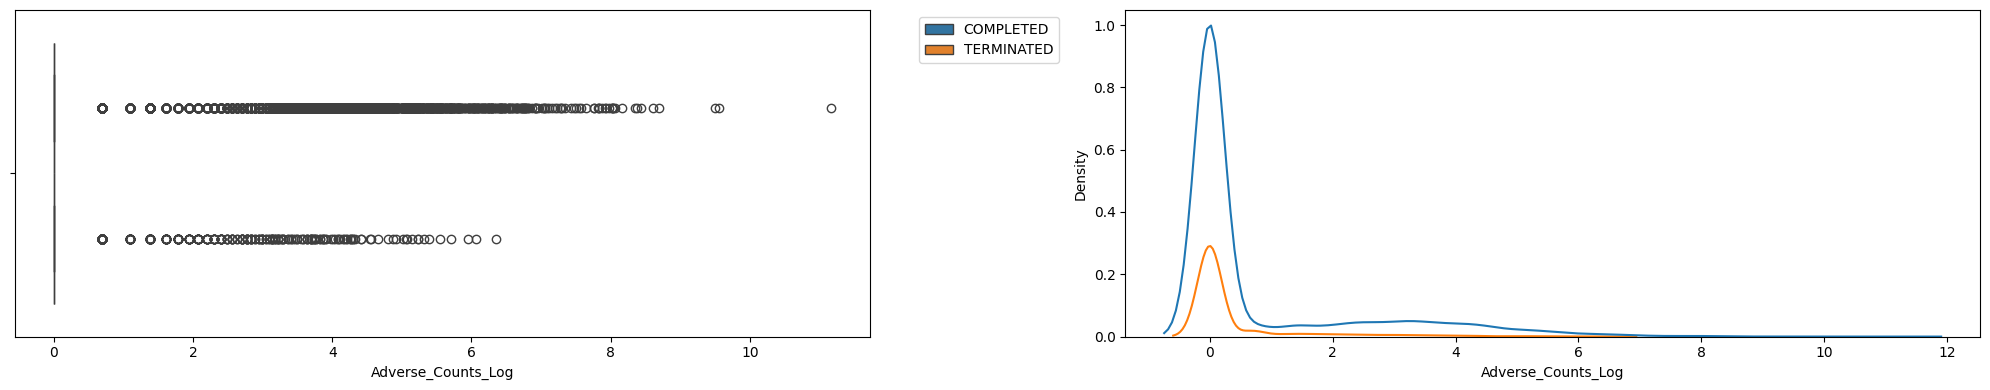

In [724]:
Adverse_Counts_Log = log_fun_cont("Adverse_Counts_Log", dfi, i)

### Adverse_Bin

df4-Phase4:
Adverse_Bin vs Study Status

p-value: 2.1231395168372765e-15 < 0.05

------------------------------------------------------------------------------------------------------------

df4-Phase4:
Adverse_Bin vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Adverse_Bin,,
No,8210,1912
Yes,2727,397


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.005475
Time:                        05:28:40   Log-Likelihood:                -6094.9
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 2.576e-16
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.4572      0.025    -57.386      0.000      -1.507      -1.407
Adverse_Bin    -0.4698      0.059     -7.907      0.000      -0.586      -0.353


df4-Phase4: Adverse_Bin p-values:
[const      

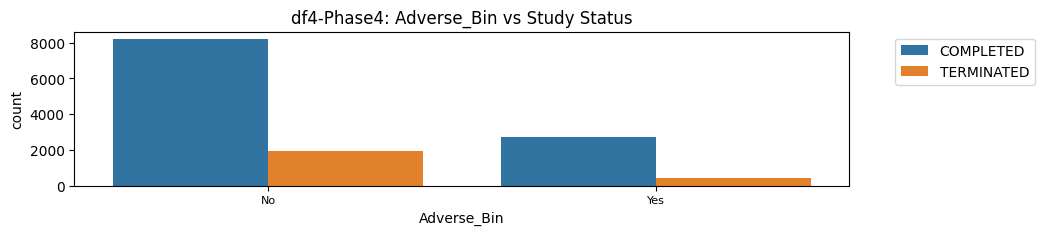

In [725]:
chi2_fun('Adverse_Bin', dfi, i)
#### log_fun
Adverse_Bin = log_fun("Adverse_Bin", dfi, i, 'bin', False, 0)

#### Format
- Risk of sparsity with categ

In [726]:
dfi = dfi.drop(columns = ['Adverse_Counts'], axis = 1)

### Adverse_System_List


df4-Phase4:
Adverse_System_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Adverse_System_List,,
Adv_Syst_Blood/ Lymphatic,587,76
Adv_Syst_Cardio,968,108
Adv_Syst_Death,337,81
Adv_Syst_Ear,307,32
Adv_Syst_Endocrine,223,29
Adv_Syst_Eye,508,58
Adv_Syst_Gastrointestinal,1641,213
Adv_Syst_General,1422,190
Adv_Syst_Genetic,82,6


SPARSITY RISK

                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13217
Method:                           MLE   Df Model:                           28
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                 0.01059
Time:                        05:28:40   Log-Likelihood:                -6063.5
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 4.646e-15
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                     -1.4729      0.025    -58.816      0.000      -1.522      -1.424
Adv_Syst_Blood/ Lymphatic       

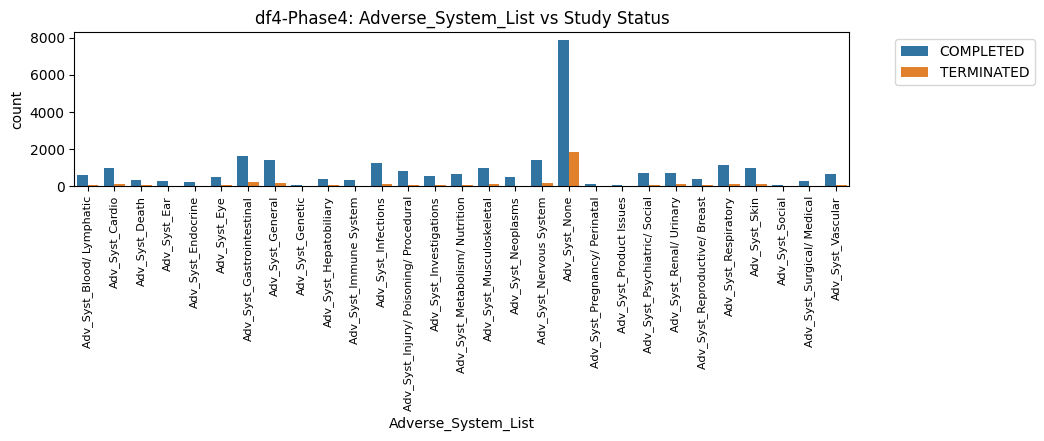

In [727]:
Adverse_System_List = log_fun("Adverse_System_List", dfi, i, 'list', False, 90, 'Adv_Syst_None')

### Adverse_System_Counts
- Different from Adverse_Counts: 
Adverse_Counts = Count of events category (e.g 100 serioues)
Adverse_System_Counts = How many organs.


df4-Phase4:
Adverse_System_Counts vs Study Status


count    13246.000000
mean         1.525970
std          3.867634
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         27.000000
Name: Adverse_System_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.006152
Time:                        05:28:41   Log-Likelihood:                -6090.8
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 3.824e-18
                            coef    std err          z      P>|z|      [0.025      0.975]
----

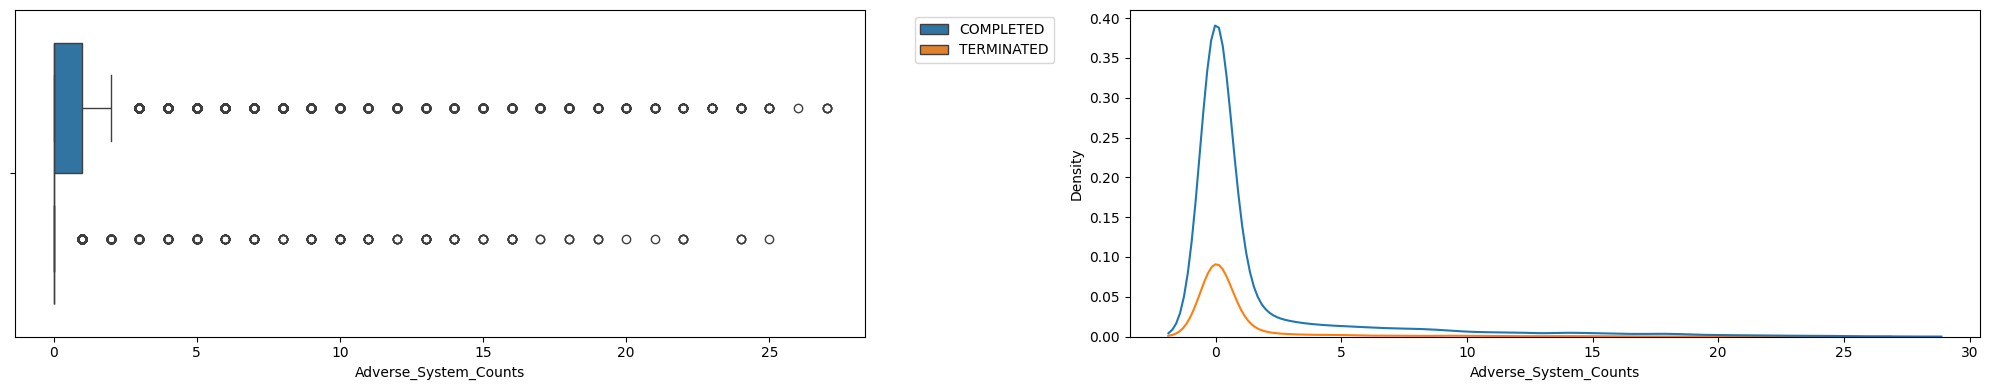

In [728]:
Adverse_System_Counts = log_fun_cont("Adverse_System_Counts", dfi, i)

### Adverse_System_Counts_Log
- Adverse_System_Counts despite mostly have the ditribution around small values (0,1,2 etc.) they also have a wide range of values in the remaining distribution.
- That is why they were checked as Log too

df4-Phase4:
Adverse_System_Counts_Log vs Study Status


count    13246.000000
mean         0.421489
std          0.811998
min          0.000000
25%          0.000000
50%          0.000000
75%          0.693147
max          3.332205
Name: Adverse_System_Counts_Log, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.007069
Time:                        05:28:42   Log-Likelihood:                -6085.1
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 1.299e-20
                                coef    std err          z      P>|z|      [0.025     

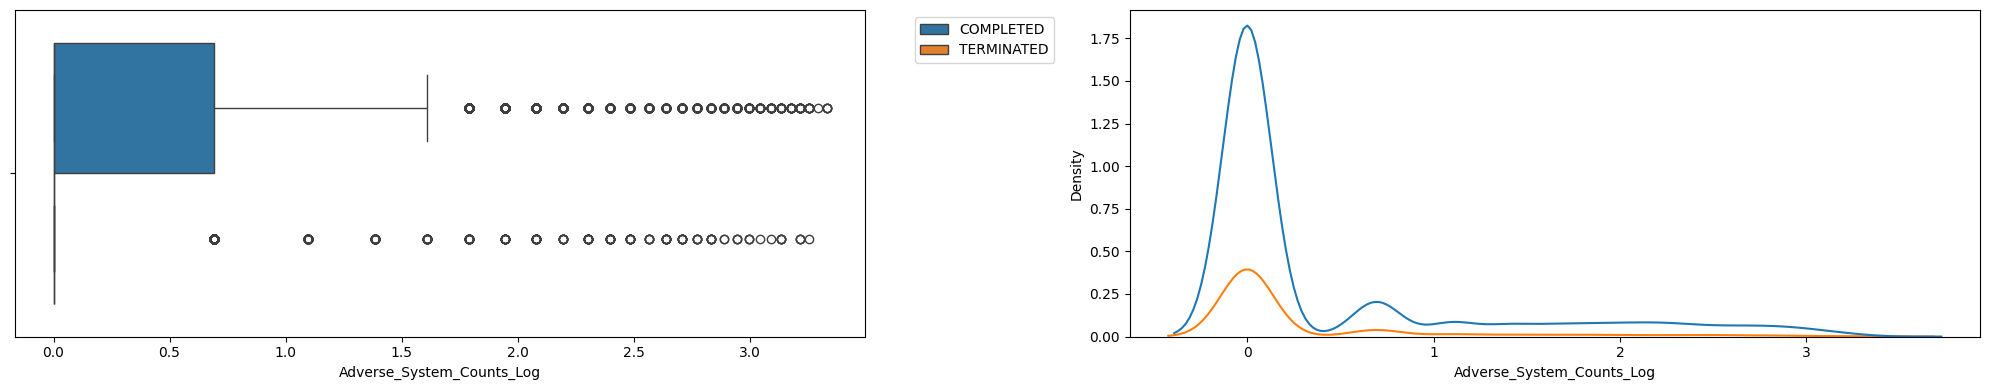

In [729]:
Adverse_System_Counts_Log = log_fun_cont("Adverse_System_Counts_Log", dfi, i)

### Adverse_System_Categ

df4-Phase4:
Adverse_System_Categ vs Study Status

p-value: 3.9184849601227705e-17 < 0.05

------------------------------------------------------------------------------------------------------------

df4-Phase4:
Adverse_System_Categ vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Adverse_System_Categ,,
0–1,8776,2026
2–27,2161,283


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.006310
Time:                        05:28:42   Log-Likelihood:                -6089.8
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 1.437e-18
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.4660      0.025    -59.475      0.000      -1.514      -1.418
Adverse_System_Categ    -0.5669      0.068     -8.355      0.000      -0.700      -0.434


df4-Phase4

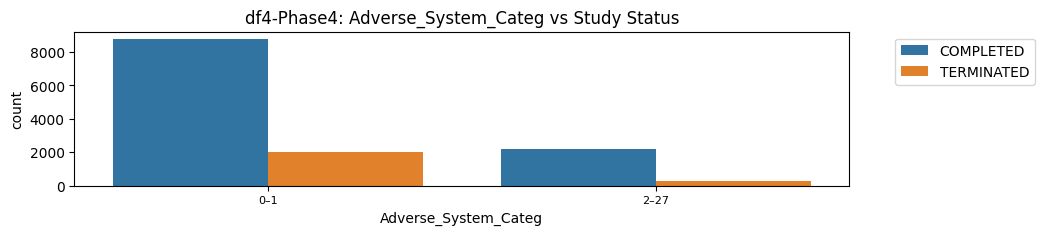

In [730]:
chi2_fun('Adverse_System_Categ', dfi, i)

#### log_fun
Adverse_System_Categ = log_fun('Adverse_System_Categ', dfi, i, 'bin', True, 0)


dfi = dfi.drop(columns = ['Adverse_Counts', 'Adverse_Bin'], axis = 1)

#### Format
- Risk of Sparsity with Categ

In [731]:
dfi = dfi.drop(columns = ['Adverse_System_Counts', 'Adverse_System_Categ'], axis = 1)

## Placebo_Bin

df4-Phase4:
Placebo_Bin vs Study Status

p-value: 0.34838900317885513 > 0.05 - No significant difference

------------------------------------------------------------------------------------------------------------

df4-Phase4:
Placebo_Bin vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Placebo_Bin,,
No,8270,1724
Yes,2667,585


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:               7.545e-05
Time:                        05:28:43   Log-Likelihood:                -6128.0
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                    0.3362
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.5680      0.026    -59.224      0.000      -1.620      -1.516
Placebo_Bin     0.0509      0.053      0.964      0.335      -0.053       0.154


df4-Phase4: Placebo_Bin p-values:
[const      

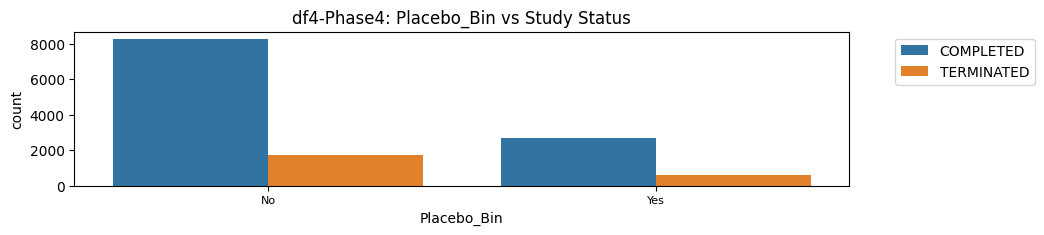

In [732]:
chi2_fun("Placebo_Bin", dfi, i)
### log_fun
Placebo_Bin = log_fun('Placebo_Bin', dfi, i, 'bin', False, 0)

## Standard_Care_Bin 

df4-Phase4:
Standard_Care_Bin vs Study Status

p-value: 2.510836850338395e-12 < 0.05

------------------------------------------------------------------------------------------------------------

df4-Phase4:
Standard_Care_Bin vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Standard_Care_Bin,,
No,10508,2141
Yes,429,168


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.003589
Time:                        05:28:43   Log-Likelihood:                -6106.5
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 3.297e-11
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.5909      0.024    -67.092      0.000      -1.637      -1.544
Standard_Care_Bin     0.6537      0.094      6.951      0.000       0.469       0.838


df4-Phase4: Standard_C

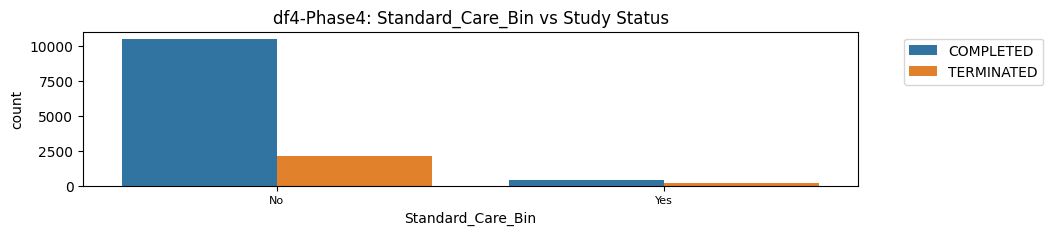

In [733]:
chi2_fun("Standard_Care_Bin", dfi, i)
### log_fun
Standard_Care_Bin = log_fun('Standard_Care_Bin', dfi, i, 'bin', False, 0)

## Healthy_Bin

df4-Phase4:
Healthy_Bin vs Study Status

p-value: 1.8606866993549577e-20 < 0.05

------------------------------------------------------------------------------------------------------------

df4-Phase4:
Healthy_Bin vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Healthy_Bin,,
No,8241,1947
Yes,2696,362


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.007567
Time:                        05:28:43   Log-Likelihood:                -6082.1
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 5.934e-22
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.4428      0.025    -57.258      0.000      -1.492      -1.393
Healthy_Bin    -0.5651      0.061     -9.206      0.000      -0.685      -0.445


df4-Phase4: Healthy_Bin p-values:
[const      

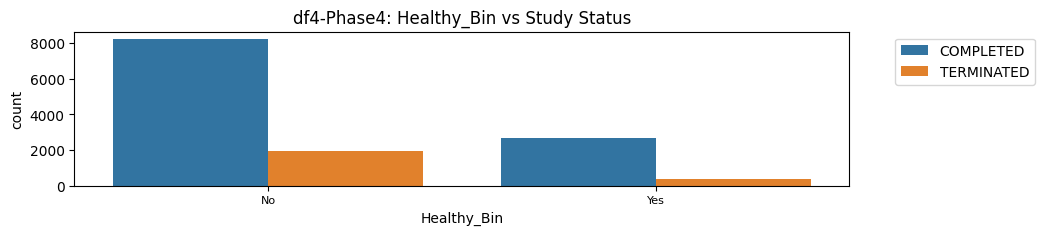

In [734]:
chi2_fun("Healthy_Bin", dfi, i)
### log_fun
Healthy_Bin = log_fun('Healthy_Bin', dfi, i, 'bin', False, 0)

## Covid_19_Bin

df4-Phase4:
Covid_19_Bin vs Study Status

p-value: 0.03720927677639237 < 0.05

------------------------------------------------------------------------------------------------------------

df4-Phase4:
Covid_19_Bin vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Covid_19_Bin,,
No,10832,2275
Yes,105,34


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:               0.0003592
Time:                        05:28:44   Log-Likelihood:                -6126.3
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                   0.03587
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.5605      0.023    -67.665      0.000      -1.606      -1.515
Covid_19_Bin     0.4329      0.199      2.179      0.029       0.044       0.822


df4-Phase4: Covid_19_Bin p-values:
[const 

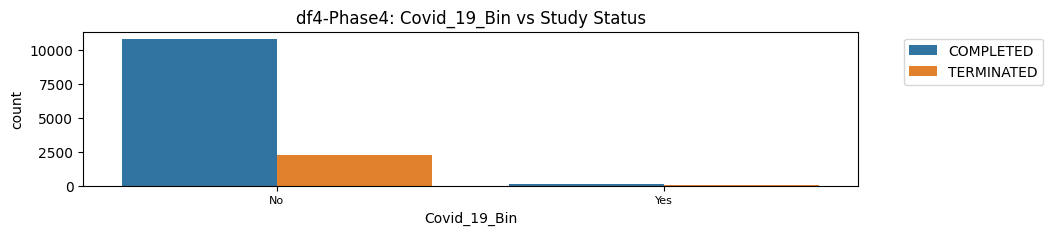

In [735]:
chi2_fun("Covid_19_Bin", dfi, i)
### log_fun
Covid_19_Bin = log_fun('Covid_19_Bin', dfi, i, 'bin', False, 0)

## Conditions_Detail_List

df4-Phase4:
Conditions_Detail_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Conditions_Detail_List,,
Bacterial Infections and Mycoses,1299,285
Cardiovascular,1414,353
Chemical Disorders,186,56
Cond_Detail_Other,794,107
"Digestive System, Nutritional, Metabolic",2027,448
Education,1,0
Endocrine System,895,177
Eye,404,74
Health Care,94,26


SPARSITY RISK

                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13219
Method:                           MLE   Df Model:                           26
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.009746
Time:                        05:28:44   Log-Likelihood:                -6068.7
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 6.163e-14
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
const                                              -1.7944      0.049    -36.445      0.000      -1.891      -1.698
Bacte

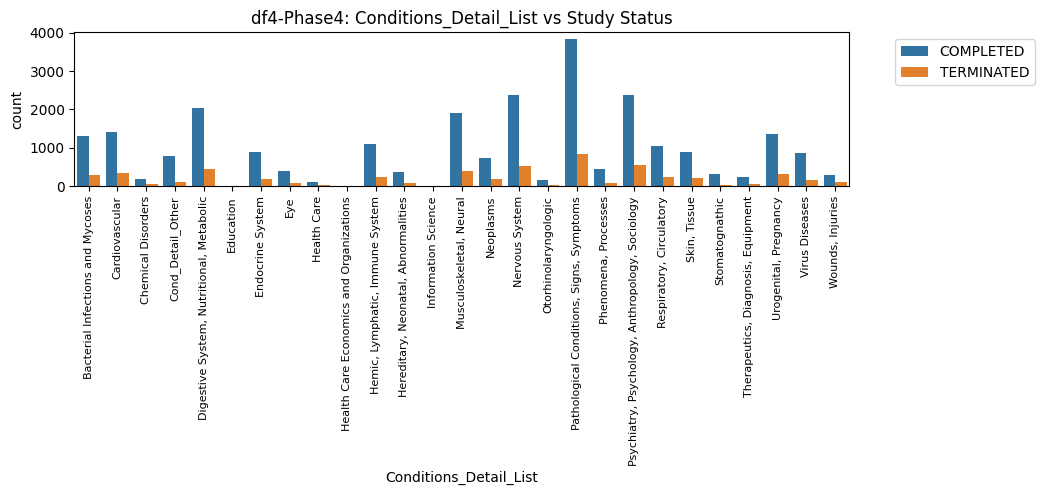

In [736]:
Conditions_Detail_List = log_fun("Conditions_Detail_List", dfi, i, 'list', False, 90, 'Cond_Detail_Other' )

## Funder_Industry_Bin

df4-Phase4:
Funder_Industry_Bin vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Funder_Industry_Bin,,
FUNDER_OTHER,8825,1933
INDUSTRY,2112,376


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:               0.0009611
Time:                        05:28:45   Log-Likelihood:                -6122.6
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 0.0005986
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.5185      0.025    -60.469      0.000      -1.568      -1.469
Funder_Industry_Bin    -0.2073      0.061     -3.378      0.001      -0.327      -0.087


df4-Phase4: Fu

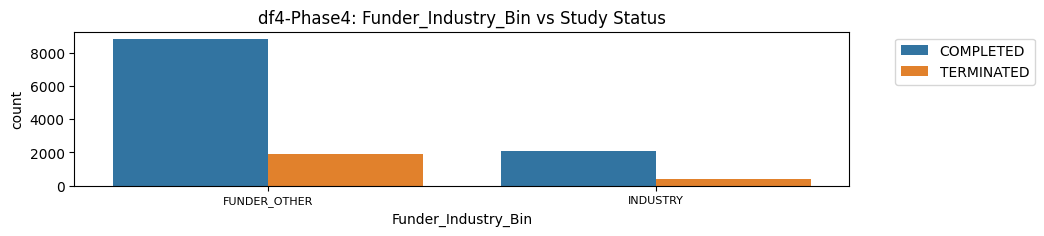

In [737]:
Funder_Industry_Bin = log_fun("Funder_Industry_Bin", dfi, i, 'bin', False, 0, 'FUNDER_OTHER')

## Age_List

df4-Phase4:
Age_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Age_List,,
ADULT,10002,2148
CHILD,1747,296
OLDER_ADULT,8152,1895


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13243
Method:                           MLE   Df Model:                            2
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.005157
Time:                        05:28:45   Log-Likelihood:                -6096.9
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 1.879e-14
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.8402      0.086    -21.288      0.000      -2.010      -1.671
ADULT          -0.0939      0.099     -0.951      0.342      -0.288       0.100
OLDER_ADULT     0.4736      0.065      7.272    

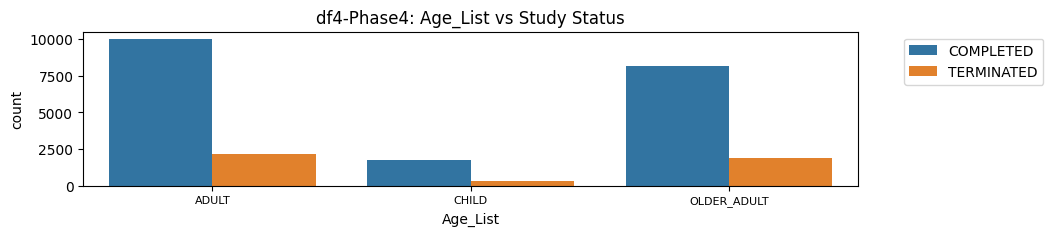

In [738]:
Age_List = log_fun("Age_List", dfi, i, 'list', False, 0, 'CHILD')

## Sex_List


df4-Phase4:
Sex_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Sex_List,,
ALL,9327,2004
FEMALE,1267,255
MALE,343,50


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13243
Method:                           MLE   Df Model:                            2
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:               0.0006165
Time:                        05:28:45   Log-Likelihood:                -6124.7
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                   0.02287
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5378      0.025    -62.458      0.000      -1.586      -1.490
FEMALE        -0.0651      0.073     -0.892      0.372      -0.208       0.078
MALE          -0.3884      0.153     -2.532      0.0

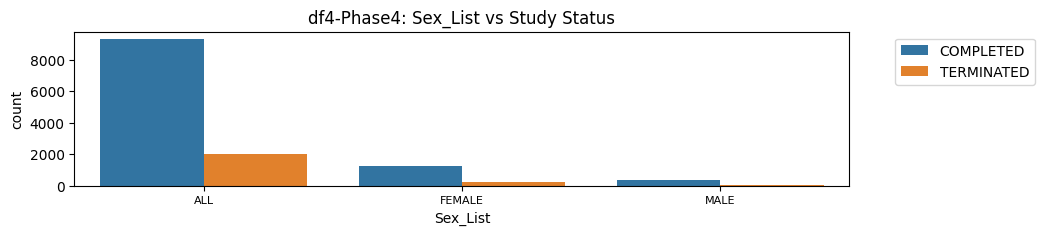

In [739]:
Sex_List = log_fun("Sex_List", dfi, i, 'list', False, 0, 'ALL')

## Study Design

### Allocation_List

df4-Phase4:
Allocation_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Allocation_List,,
NA_RANDOMIZED,1929,447
NON_RANDOMIZED,724,156
RANDOMIZED,8284,1706


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13243
Method:                           MLE   Df Model:                            2
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:               0.0003278
Time:                        05:28:46   Log-Likelihood:                -6126.5
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                    0.1341
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.4622      0.052    -27.855      0.000      -1.565      -1.359
NON_RANDOMIZED    -0.0727      0.103     -0.708      0.479      -0.274       0.129
RANDOMIZED        -0.1179      0.059

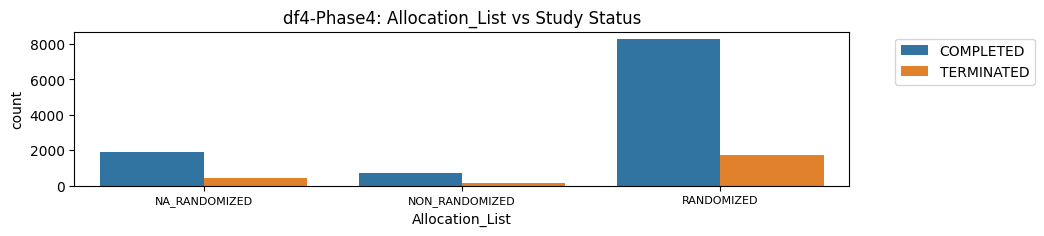

In [740]:
Allocation_List = log_fun("Allocation_List", dfi, i, 'list', False, 0, 'NA_RANDOMIZED')

### Masking_List


df4-Phase4:
Masking_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Masking_List,,
DOUBLE,1587,282
MASK_NONE,5147,1204
QUADRUPLE,1647,366
SINGLE,1364,240
TRIPLE,1192,217


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13241
Method:                           MLE   Df Model:                            4
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.002404
Time:                        05:28:46   Log-Likelihood:                -6113.7
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 6.286e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4527      0.032    -45.379      0.000      -1.515      -1.390
DOUBLE        -0.2750      0.072     -3.813      0.000      -0.416      -0.134
QUADRUPLE     -0.0513      0.066     -0.777      0.4

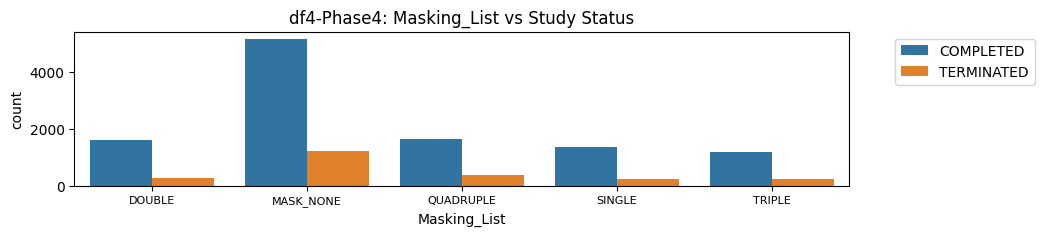

In [741]:
Masking_List = log_fun("Masking_List", dfi, i, 'list', False, 0, 'MASK_NONE')

### Masking_Detail_List

df4-Phase4:
Masking_Detail_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Masking_Detail_List,,
CARE_PROVIDER,2684,587
INVESTIGATOR,3887,763
MASK_DET_NONE,5147,1204
OUTCOMES_ASSESSOR,3334,608
PARTICIPANT,4797,961


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13241
Method:                           MLE   Df Model:                            4
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.002748
Time:                        05:28:46   Log-Likelihood:                -6111.6
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 8.663e-07
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.4890      0.031    -48.475      0.000      -1.549      -1.429
CARE_PROVIDER         0.3046      0.073      4.151      0.000       0.161       0.448
INVESTIGATOR         -0.

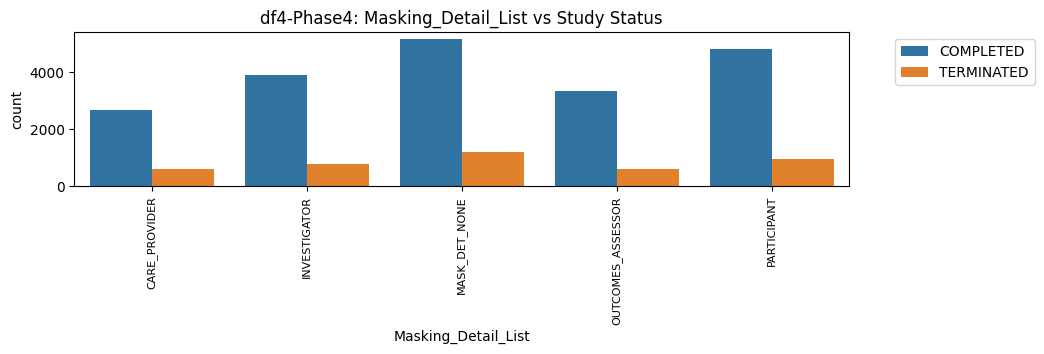

In [742]:
Masking_Detail_List = log_fun("Masking_Detail_List", dfi, i, 'list', False, 90, 'MASK_DET_NONE')


### Primary_Purpose_List


df4-Phase4:
Primary_Purpose_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Primary_Purpose_List,,
BASIC_SCIENCE,466,81
DIAGNOSTIC,247,70
HEALTH_SERVICES_RESEARCH,120,23
PREVENTION,1619,235
PRIM_PURP_OTHER,563,127
SCREENING,49,4
SUPPORTIVE_CARE,414,90
TREATMENT,7459,1679


SPARSITY RISK

                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13238
Method:                           MLE   Df Model:                            7
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.004033
Time:                        05:28:47   Log-Likelihood:                -6103.8
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 1.869e-08
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.4894      0.098    -15.160      0.000      -1.682      -1.297
BASIC_SCIENCE               -0.2602      0.155     -1.675      0.094      

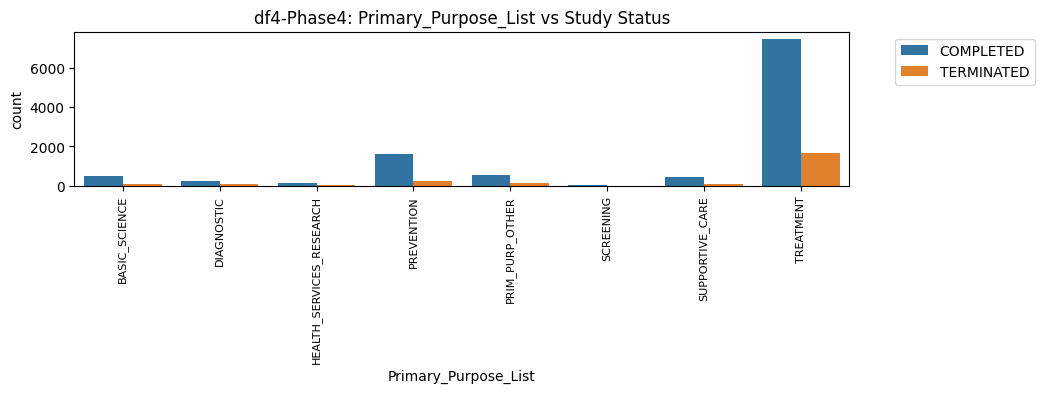

In [743]:
Primary_Purpose_List = log_fun("Primary_Purpose_List", dfi, i, 'list', False, 90, 'PRIM_PURP_OTHER')

## Arms

### Arm_Counts

df4-Phase4:
Arm_Counts vs Study Status


count    13246.000000
mean         2.089989
std          0.988447
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         32.000000
Name: Arm_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.002739
Time:                        05:28:47   Log-Likelihood:                -6111.7
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 6.873e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

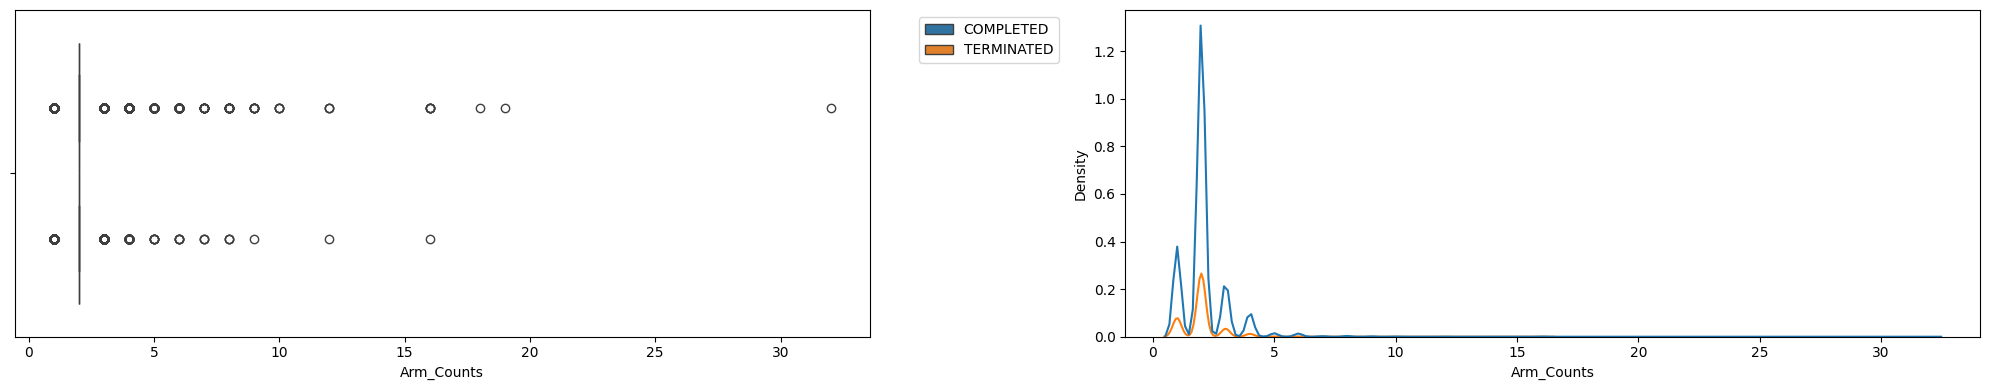

In [744]:
Arm_Counts = Arm_Counts = log_fun_cont("Arm_Counts", dfi, i)

### Arm_Counts_Log
- Arm_Counts despite mostly have the ditribution around small values (0,1,2 etc.) they also have a wide range of values in the remaining distribution.
- That is why they were checked as Log too

df4-Phase4:
Arm_Counts vs Study Status


count    13246.000000
mean         2.089989
std          0.988447
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         32.000000
Name: Arm_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.002739
Time:                        05:28:48   Log-Likelihood:                -6111.7
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 6.873e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

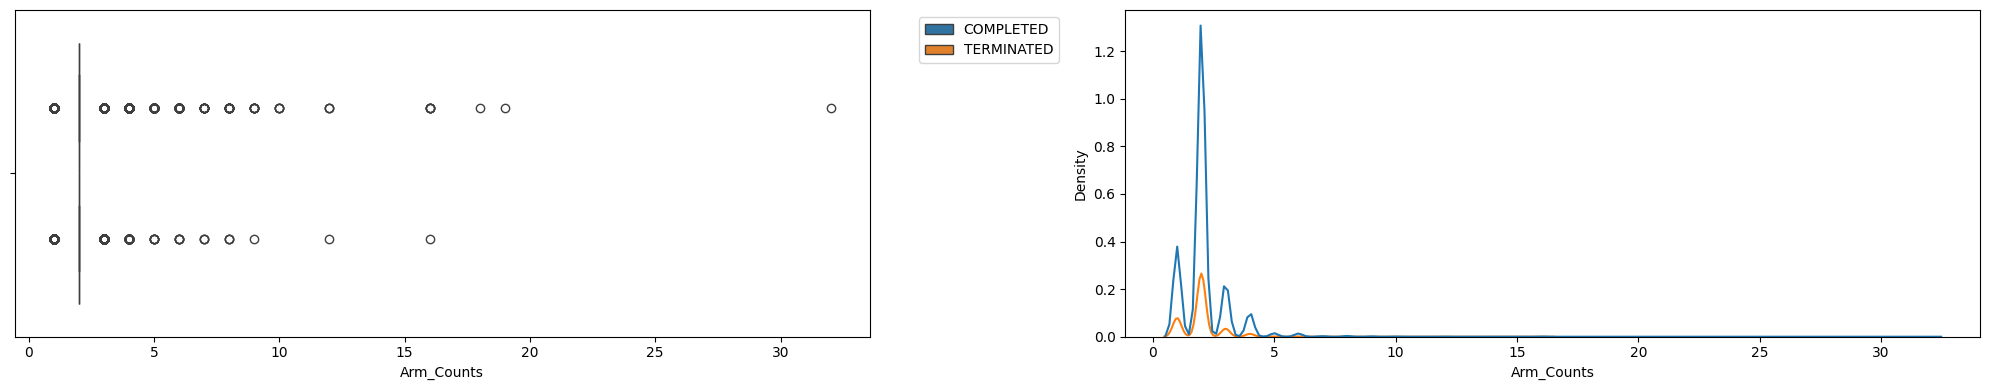

In [745]:
Arm_Counts_Log = Arm_Counts_Log = log_fun_cont("Arm_Counts", dfi, i)

### Arm_Categ

df4-Phase4:
Arm_Categ vs Study Status

p-value: 4.277685805812983e-10 < 0.05

------------------------------------------------------------------------------------------------------------

df4-Phase4:
Arm_Categ vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Arm_Categ,,
1–2,8989,2022
3–32,1948,287


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.003420
Time:                        05:28:48   Log-Likelihood:                -6107.5
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 9.533e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4919      0.025    -60.615      0.000      -1.540      -1.444
Arm_Categ     -0.4232      0.068     -6.237      0.000      -0.556      -0.290


df4-Phase4: Arm_Categ p-values:
[const        0.00

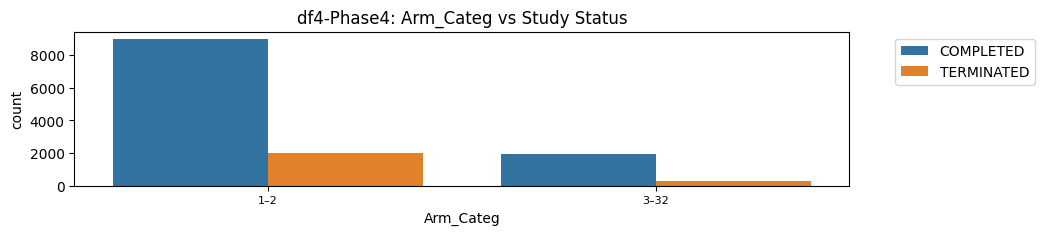

In [746]:
chi2_fun('Arm_Categ', dfi, i)
#### Log_Fun
Arm_Categ = log_fun('Arm_Categ', dfi, i, 'bin', True, 0)

#### Format
- Risk of Sparsity with categ

In [747]:
dfi = dfi.drop(columns = ['Arm_Counts', 'Arm_Categ'], axis = 1)

## Intervention_Model_List

df4-Phase4:
Intervention_Model_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Intervention_Model_List,,
CROSSOVER,952,123
FACTORIAL,140,36
PARALLEL,7559,1598
SEQUENTIAL,89,14
SINGLE_GROUP,2197,538


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13241
Method:                           MLE   Df Model:                            4
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.003361
Time:                        05:28:49   Log-Likelihood:                -6107.9
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 2.445e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4070      0.048    -29.250      0.000      -1.501      -1.313
CROSSOVER     -0.6393      0.107     -5.963      0.000      -0.849      -0.429
FACTORIAL      0.0486      0.193      0.252      0.8

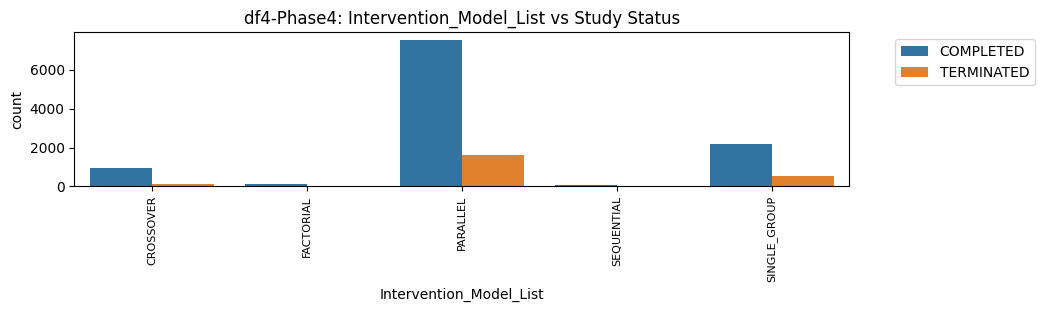

In [748]:
Intervention_Model_List = log_fun("Intervention_Model_List", dfi, i, 'list', False, 90, 'SINGLE_GROUP' )

## Intervention_Type_List

df4-Phase4:
Intervention_Type_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Intervention_Type_List,,
BEHAVIORAL,200,42
BIOLOGICAL,646,68
COMBINATION_PRODUCT,75,18
DEVICE,671,153
DIAGNOSTIC_TEST,36,13
DIETARY_SUPPLEMENT,205,24
DRUG,8501,1882
GENETIC,4,4
INTERV_OTHER,989,212


SPARSITY RISK

                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13235
Method:                           MLE   Df Model:                           10
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.005013
Time:                        05:28:49   Log-Likelihood:                -6097.7
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 1.932e-09
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.6389      0.065    -25.288      0.000      -1.766      -1.512
BEHAVIORAL          -5.682e-05      0.172     -0.000      1.000      -0.337       0.337
B

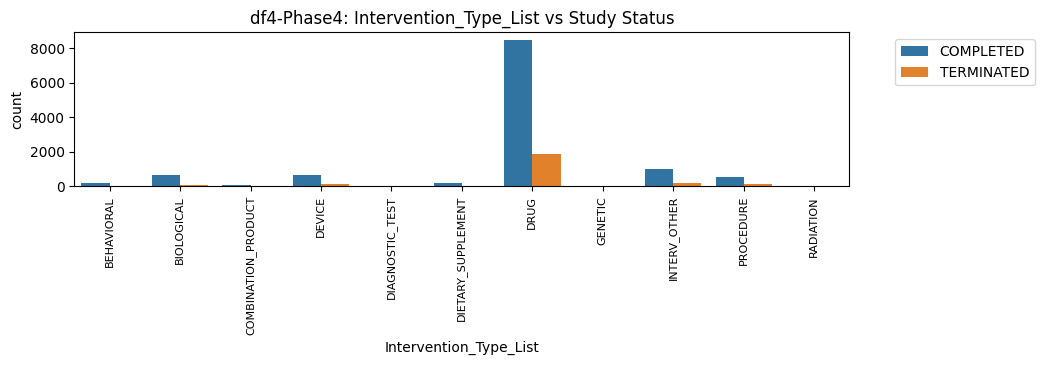

In [749]:
Intervention_Type_List = log_fun("Intervention_Type_List", dfi, i, 'list', False, 90, 'INTERV_OTHER')

## Intervention_Type_Counts


df4-Phase4:
Intervention_Type_Counts vs Study Status


count    13246.000000
mean         1.089461
std          0.304365
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          4.000000
Name: Intervention_Type_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:               0.0002066
Time:                        05:28:49   Log-Likelihood:                -6127.2
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                    0.1116
                               coef    std err          z      P>|z|      [0.025      0.

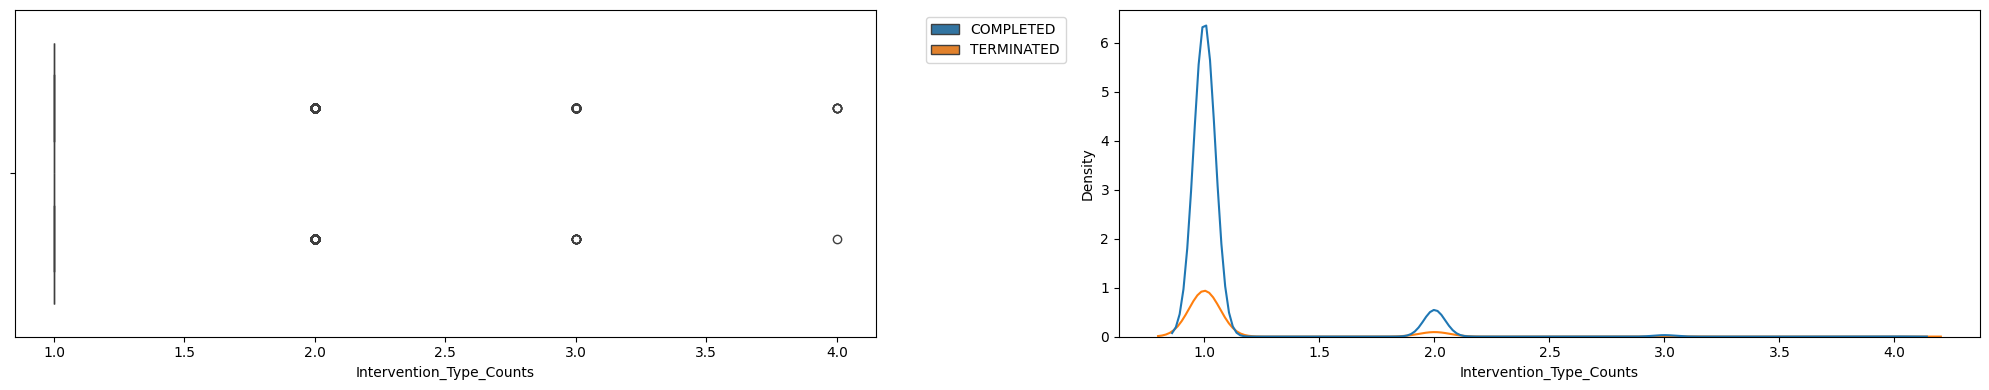

In [750]:
Intervention_Type_Counts = log_fun_cont("Intervention_Type_Counts", dfi, i)

## Intervention_Type_Categ

df4-Phase4:
Intervention_Type_Categ vs Study Status

p-value: 0.0866503578603795 > 0.05 - No significant difference

------------------------------------------------------------------------------------------------------------

df4-Phase4:
Intervention_Type_Categ vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Intervention_Type_Categ,,
1,10036,2093
2–4,901,216


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:               0.0002450
Time:                        05:28:50   Log-Likelihood:                -6127.0
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                   0.08314
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -1.5676      0.024    -65.236      0.000      -1.615      -1.521
Intervention_Type_Categ     0.1395      0.079      1.755      0.079      -0.016       0.295


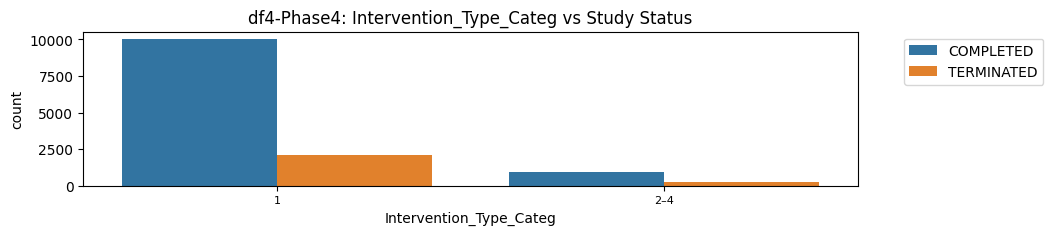

In [751]:
chi2_fun('Intervention_Type_Categ', dfi, i)
#### log_fun
Intervention_Type_Categ = log_fun('Intervention_Type_Categ', dfi, i, 'bin', True, 0)

#### Format
- As continues, it has too discrite values at 1 and a small sample at 2..
- However, sparsity risk.
- That is why _Log was not checks too.

In [752]:
dfi = dfi.drop(columns = ['Intervention_Type_Counts'], axis = 1)

## Intervention_Route

### Intervention_Route_List

df4-Phase4:
Intervention_Route_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Intervention_Route_List,,
Injection,4867,984
Inter_Route_Other,3134,706
Oral,2099,394
Surgical,2332,522
Topical,1675,327


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13241
Method:                           MLE   Df Model:                            4
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:               0.0009687
Time:                        05:28:51   Log-Likelihood:                -6122.5
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                   0.01832
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4959      0.036    -41.171      0.000      -1.567      -1.425
Injection     -0.0803      0.046     -1.731      0.083      -0.171       0.011
Oral          -0.1408      0.060     -2.328      0.0

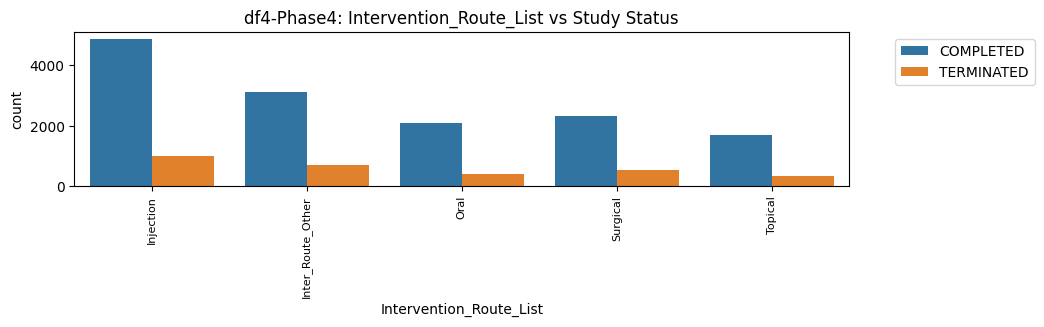

In [753]:
Intervention_Route_List = log_fun("Intervention_Route_List", dfi, i, 'list', False, 90, 'Inter_Route_Other')

### Intervention_Route_Counts

df4-Phase4:
Intervention_Route_Counts vs Study Status


count    13246.000000
mean         1.286426
std          0.516347
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: Intervention_Route_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:               0.0002271
Time:                        05:28:51   Log-Likelihood:                -6127.1
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                   0.09524
                                coef    std err          z      P>|z|      [0.025     

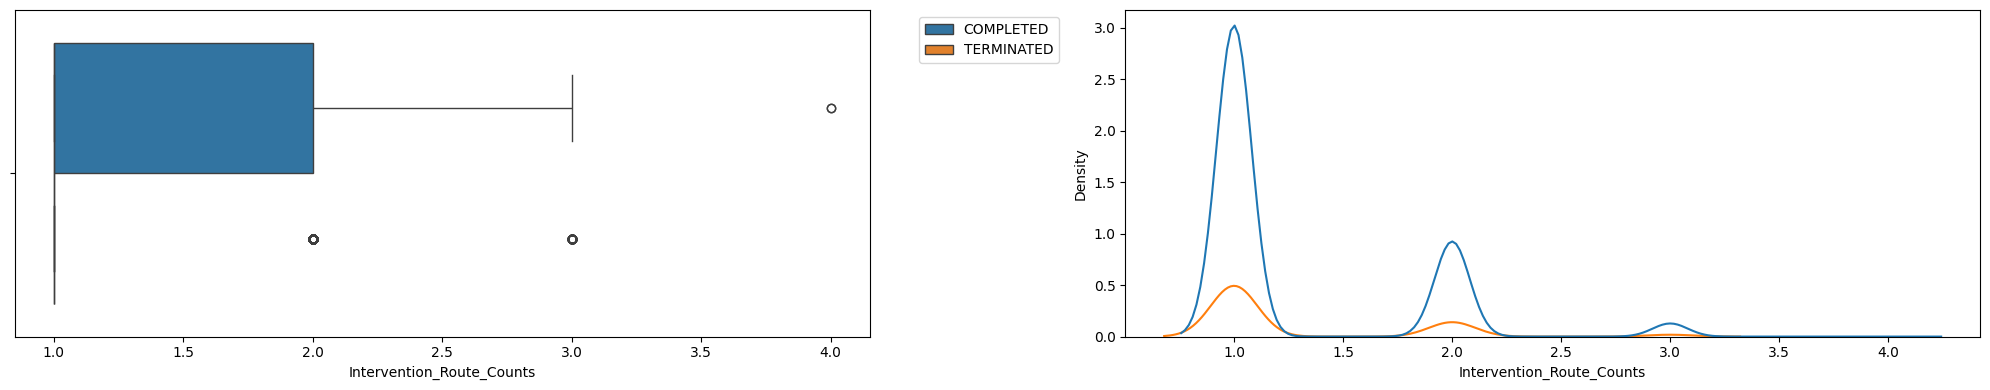

In [754]:
Intervention_Route_Counts = log_fun_cont("Intervention_Route_Counts", dfi, i)

### Intervention_Route_Categ

df4-Phase4:
Intervention_Route_Categ vs Study Status

p-value: 0.12276873124612951 > 0.05 - No significant difference

------------------------------------------------------------------------------------------------------------

df4-Phase4:
Intervention_Route_Categ vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Intervention_Route_Categ,,
1,8113,1749
2–4,2824,560


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:               0.0002028
Time:                        05:28:51   Log-Likelihood:                -6127.2
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                    0.1149
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.5345      0.026    -58.204      0.000      -1.586      -1.483
Intervention_Route_Categ    -0.0834      0.053     -1.567      0.117      -0.188       0.

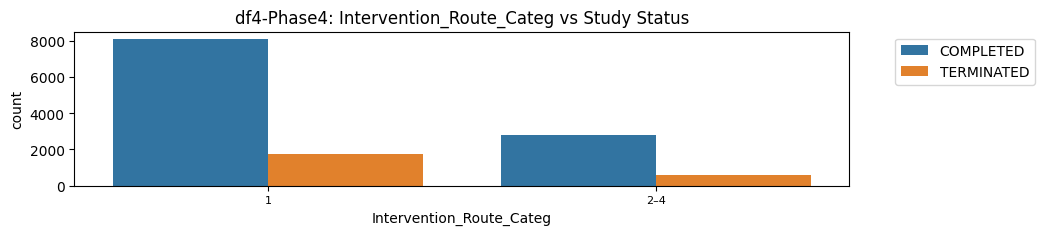

In [755]:
chi2_fun('Intervention_Route_Categ', dfi, i)
#### Log_Fun
Intervention_Route_Categ = log_fun('Intervention_Route_Categ', dfi, i, 'bin', True, 0)

#### Format
- As continues, it has too discrite values at 1 and a small sample at 2..
- That is why _Log was not checks too.

In [756]:
dfi = dfi.drop(columns = ['Intervention_Route_Counts'], axis = 1)

## Locations

### City_Counts

df4-Phase4:
City_Counts vs Study Status


count    13246.000000
mean         4.325985
std         17.885615
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        607.000000
Name: City_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.002730
Time:                        05:28:52   Log-Likelihood:                -6111.7
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 7.284e-09
                  coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------

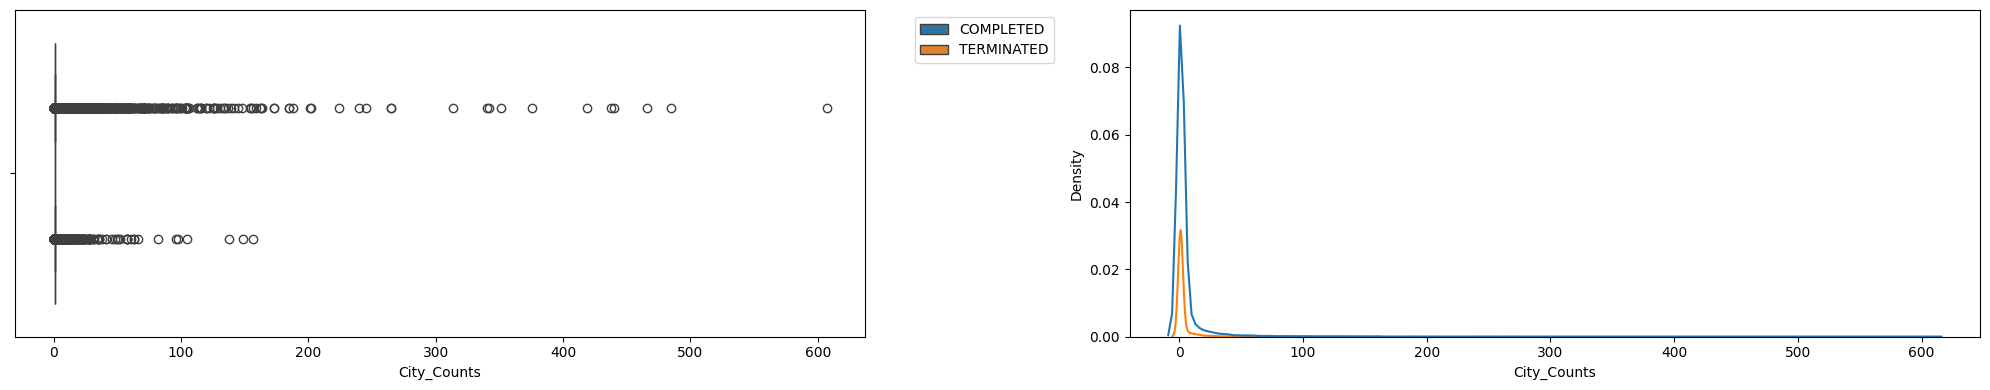

In [757]:
City_Counts = log_fun_cont("City_Counts", dfi, i)

### City_Counts_Log

df4-Phase4:
City_Counts_Log vs Study Status


count    13246.000000
mean         0.963725
std          0.819531
min          0.000000
25%          0.693147
50%          0.693147
75%          0.693147
max          6.410175
Name: City_Counts_Log, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.004472
Time:                        05:28:52   Log-Likelihood:                -6101.1
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 1.323e-13
                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------

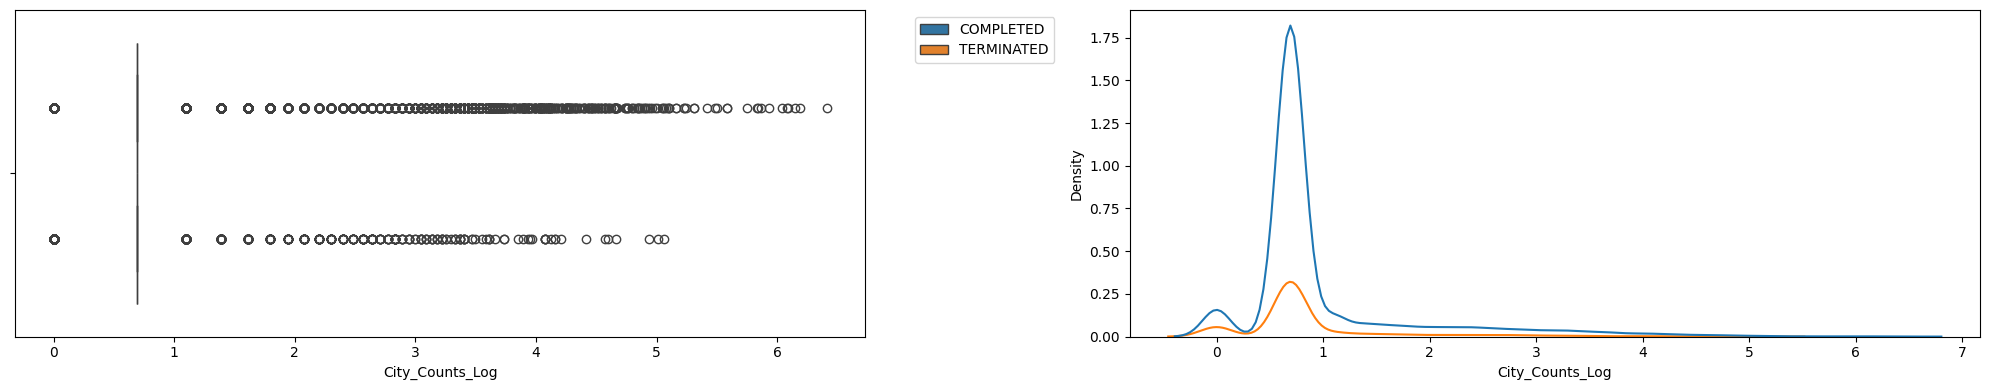

In [758]:
City_Counts_Log = log_fun_cont("City_Counts_Log", dfi, i)

### City_Categ

df4-Phase4:
City_Categ vs Study Status

p-value: 0.0003481008733635433 < 0.05

------------------------------------------------------------------------------------------------------------

df4-Phase4:
City_Categ vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
City_Categ,,
0–1,8570,1887
2–607,2367,422


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.001089
Time:                        05:28:53   Log-Likelihood:                -6121.8
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 0.0002582
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5133      0.025    -59.512      0.000      -1.563      -1.464
City_Categ    -0.2108      0.059     -3.595      0.000      -0.326      -0.096


df4-Phase4: City_Categ p-values:
[const         0.

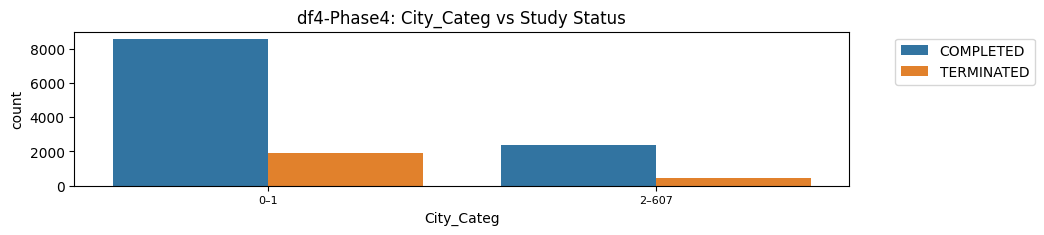

In [759]:
chi2_fun('City_Categ', dfi, i)
#### log_fun
City_Categ = log_fun('City_Categ', dfi, i, 'bin', False, 0)

#### Format
- Distribution is almost all at 1.
- Howver, the question answered from this feature is if multi vs single facilities.
- Categ is goind to be used. 


In [760]:
dfi = dfi.drop(columns = ['City_Counts', 'City_Categ'], axis = 1)

### Country_Counts


df4-Phase4:
Country_Counts vs Study Status


count    13246.000000
mean         1.234033
std          1.948536
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         42.000000
Name: Country_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.002985
Time:                        05:28:53   Log-Likelihood:                -6110.2
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 1.463e-09
                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

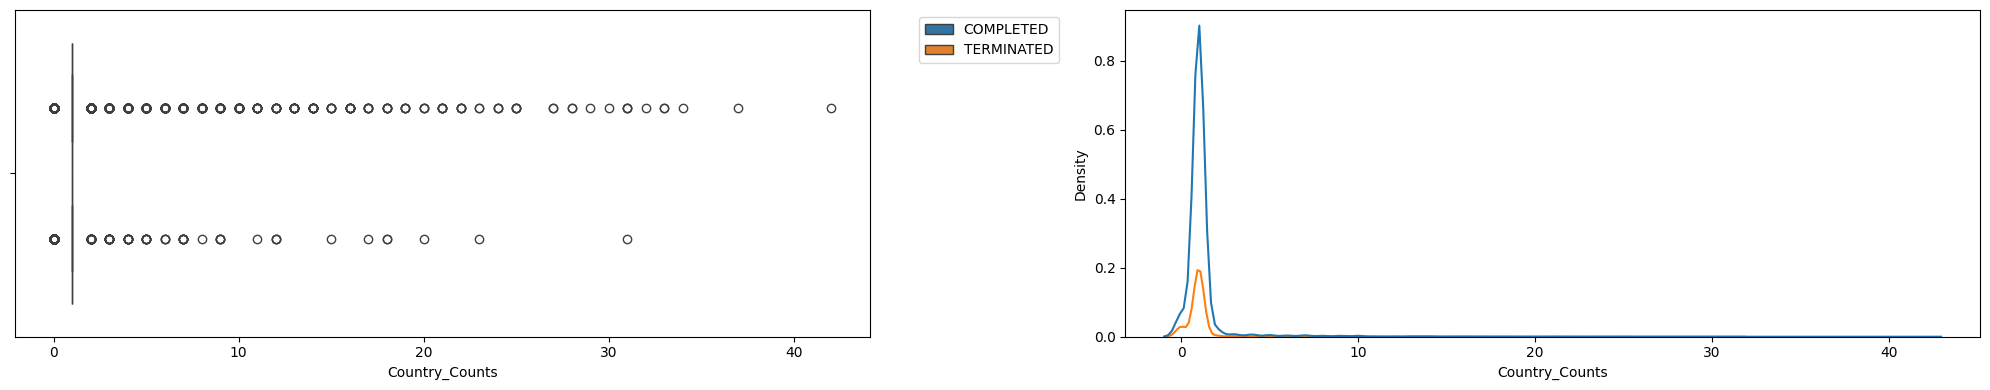

In [761]:
Country_Counts = log_fun_cont("Country_Counts", dfi, i)

### Country_Counts_Log

df4-Phase4:
Countries_Counts_Log vs Study Status


count    13246.000000
mean         0.704050
std          0.350663
min          0.000000
25%          0.693147
50%          0.693147
75%          0.693147
max          3.761200
Name: Countries_Counts_Log, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.007313
Time:                        05:28:54   Log-Likelihood:                -6083.6
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 2.856e-21
                           coef    std err          z      P>|z|      [0.025      0.975]
-------

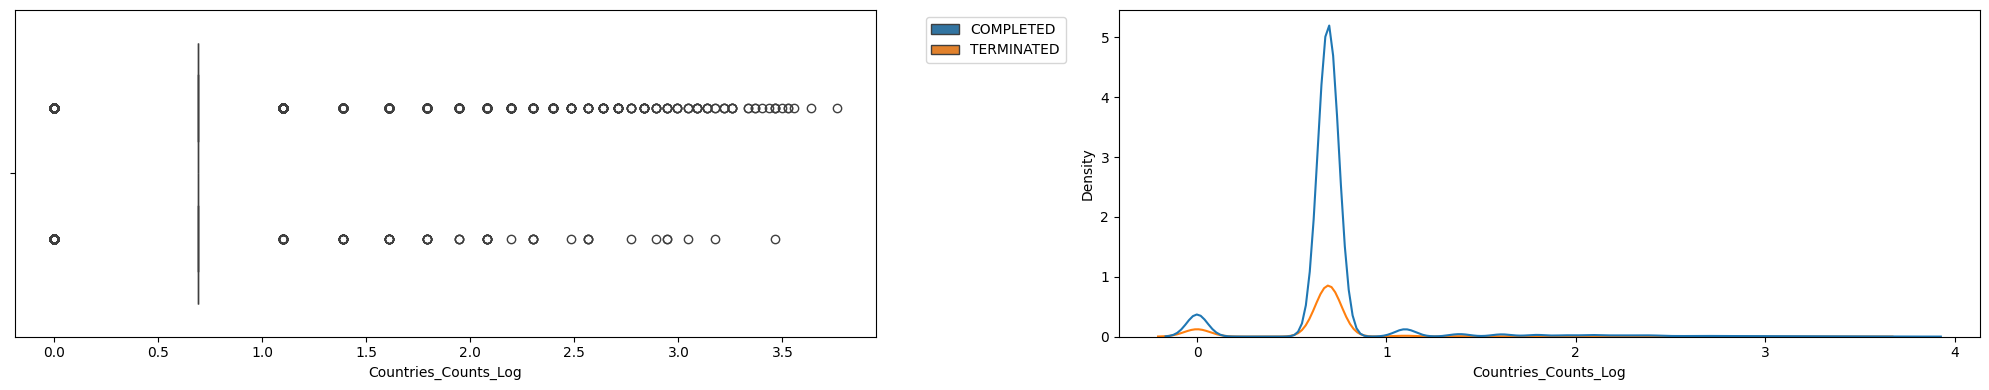

In [762]:
Countries_Counts_Log = log_fun_cont("Countries_Counts_Log", dfi, i)

### Country_Categ

df4-Phase4:
Country_Categ vs Study Status

p-value: 8.722245735910154e-06 < 0.05

------------------------------------------------------------------------------------------------------------

df4-Phase4:
Country_Categ vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Country_Categ,,
0–1,10257,2221
2–42,680,88


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.001820
Time:                        05:28:54   Log-Likelihood:                -6117.3
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 2.317e-06
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.5300      0.023    -65.374      0.000      -1.576      -1.484
Country_Categ    -0.5152      0.116     -4.453      0.000      -0.742      -0.288


df4-Phase4: Country_Categ p-values:
[c

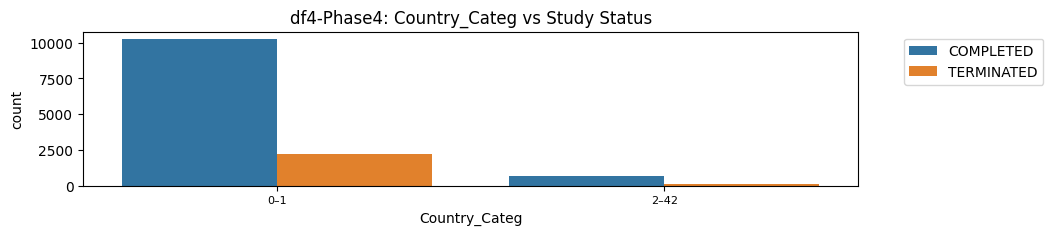

In [763]:
chi2_fun('Country_Categ', dfi, i)
#### log_fun
Country_Categ = log_fun('Country_Categ', dfi, i, 'bin', True, 0)

#### Format
- Sparse Risk with categ
- However, the question to answer is global/non-global trials.


In [764]:
dfi = dfi.drop(columns = ['Country_Counts', 'Country_Categ'], axis = 1)

### Continents_List 

df4-Phase4:
Continents_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Continents_List,,
Africa,845,33
Asia,2611,215
Cont_Other,974,282
Europe,2900,469
North America,3687,1323
Oceania,154,24
South America,477,48


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13239
Method:                           MLE   Df Model:                            6
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                 0.05816
Time:                        05:28:55   Log-Likelihood:                -5772.1
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                1.051e-150
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.3627      0.061    -22.427      0.000      -1.482      -1.244
Africa           -1.8146      0.186     -9.749      0.000      -2.179      -1.450
Asia             -1.0993      0.091    -

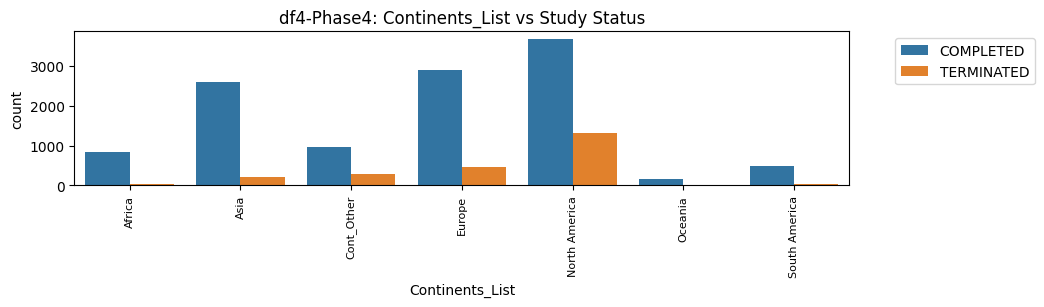

In [765]:
Continents_List = log_fun("Continents_List", dfi, i, 'list', False, 90, 'Cont_Other')

### Continent_Counts

df4-Phase4:
Continent_Counts vs Study Status


count    13246.000000
mean         0.965273
std          0.493064
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: Continent_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.002644
Time:                        05:28:55   Log-Likelihood:                -6112.3
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 1.249e-08
                       coef    std err          z      P>|z|      [0.025      0.975]
-------------------

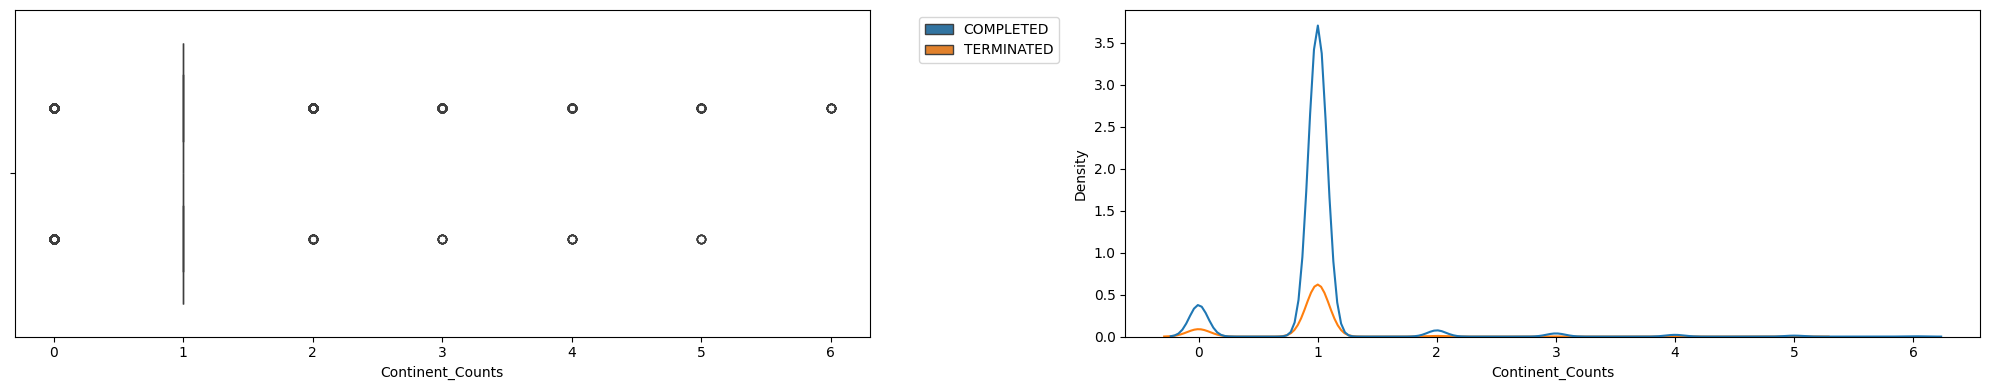

In [766]:
Continent_Counts = log_fun_cont("Continent_Counts", dfi, i)

### Continent_Counts_Log

df4-Phase4:
Continent_Counts_Log vs Study Status


count    13246.000000
mean         0.647545
std          0.241108
min          0.000000
25%          0.693147
50%          0.693147
75%          0.693147
max          1.945910
Name: Continent_Counts_Log, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.002737
Time:                        05:28:56   Log-Likelihood:                -6111.7
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 6.962e-09
                           coef    std err          z      P>|z|      [0.025      0.975]
-------

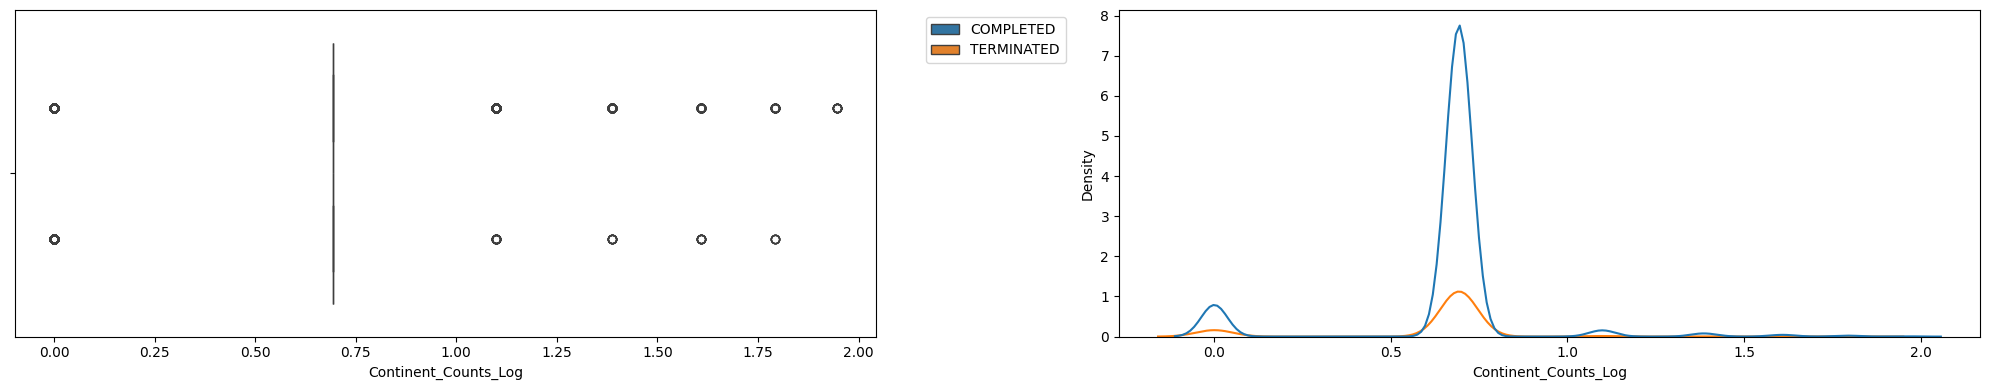

In [767]:
Continent_Counts_Log = log_fun_cont("Continent_Counts_Log", dfi, i)

### Continent_Categ

df4-Phase4:
Continent_Categ vs Study Status

p-value: 0.00029235048064018084 < 0.05

------------------------------------------------------------------------------------------------------------

df4-Phase4:
Continent_Categ vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Continent_Categ,,
0–1,10556,2263
2–6,381,46


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.001245
Time:                        05:28:56   Log-Likelihood:                -6120.8
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 9.363e-05
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.5400      0.023    -66.480      0.000      -1.585      -1.495
Continent_Categ    -0.5745      0.158     -3.640      0.000      -0.884      -0.265


df4-Phase4: Continent_Categ p-

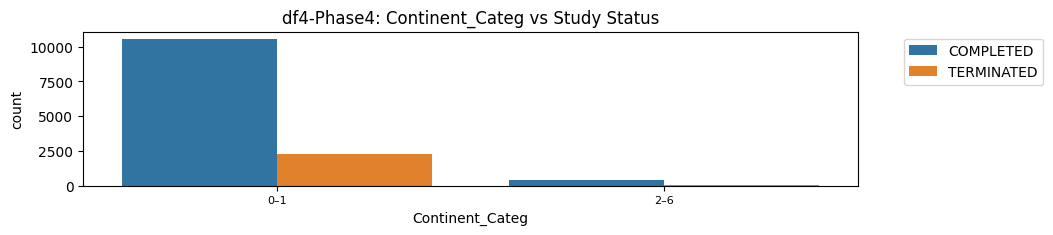

In [768]:
chi2_fun('Continent_Categ', dfi, i)
#### log_fun
Continent_Categ = log_fun('Continent_Categ', dfi, i, 'bin', True, 0)

#### Format
- Sparsity Risk with categ.
- However, question answered is global/global
- Will all Continent counts be dropped, as the global/non-global is answered through countries as well. 
- Also, Continenets are have more sparse risk than Countries.

In [769]:
dfi = dfi.drop(columns = ['Continent_Counts', 'Continent_Counts_Log', 'Continent_Categ'])

## Datetimes

### Start_Date_Year_Counts

df4-Phase4:
Start_Date_Year_Counts vs Study Status


count        13246.0
mean     2016.058735
std         3.454502
min           2011.0
25%           2013.0
50%           2016.0
75%           2019.0
max           2024.0
Name: Start_Date_Year_Counts, dtype: Float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.002137
Time:                        05:28:57   Log-Likelihood:                -6115.4
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 3.098e-07
                             coef    std err          z      P>|z|      [0.025      0.975]
---------

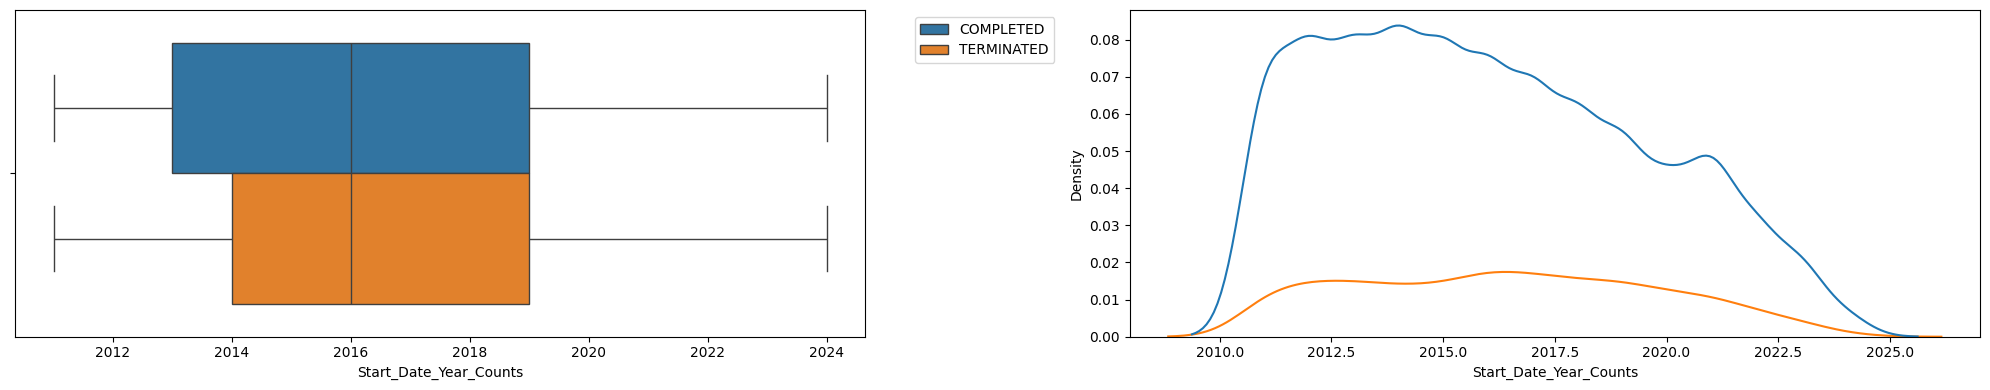

In [770]:
Start_Date_Year_Counts = log_fun_cont("Start_Date_Year_Counts", dfi, i)

### Start_Date_Year_Categ
- Categorization is covid dates oriented

df4-Phase4:
Start_Date_Year_Categ vs Study Status

p-value: 0.0001326445698159316 < 0.05

------------------------------------------------------------------------------------------------------------

df4-Phase4:
Start_Date_Year_Categ vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Start_Date_Year_Categ,,
2011-2018,8122,1625
2019-2024,2815,684


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.001185
Time:                        05:28:57   Log-Likelihood:                -6121.2
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 0.0001385
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.6091      0.027    -59.211      0.000      -1.662      -1.556
Start_Date_Year_Categ     0.1943      0.051      3.844      0.000       0.095       0.293


df4-Ph

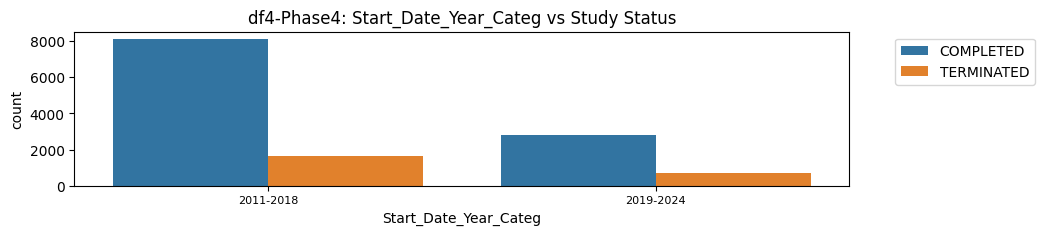

In [771]:
chi2_fun("Start_Date_Year_Categ", dfi, i)
#### log_fun
Start_Date_Year_Categ = log_fun("Start_Date_Year_Categ", dfi, i, 'bin', True, 0)

### Completion_Date_Year 
- will not run AIC --> Date - Year itself is not a feature affecting the outcome.



df4-Phase4:
Completion_Date_Year_Counts vs Study Status


count        13246.0
mean     2018.139967
std         3.469508
min           2011.0
25%           2015.0
50%           2018.0
75%           2021.0
max           2024.0
Name: Completion_Date_Year_Counts, dtype: Float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.002528
Time:                        05:28:58   Log-Likelihood:                -6113.0
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 2.596e-08
                                  coef    std err          z      P>|z|      [0.025      0

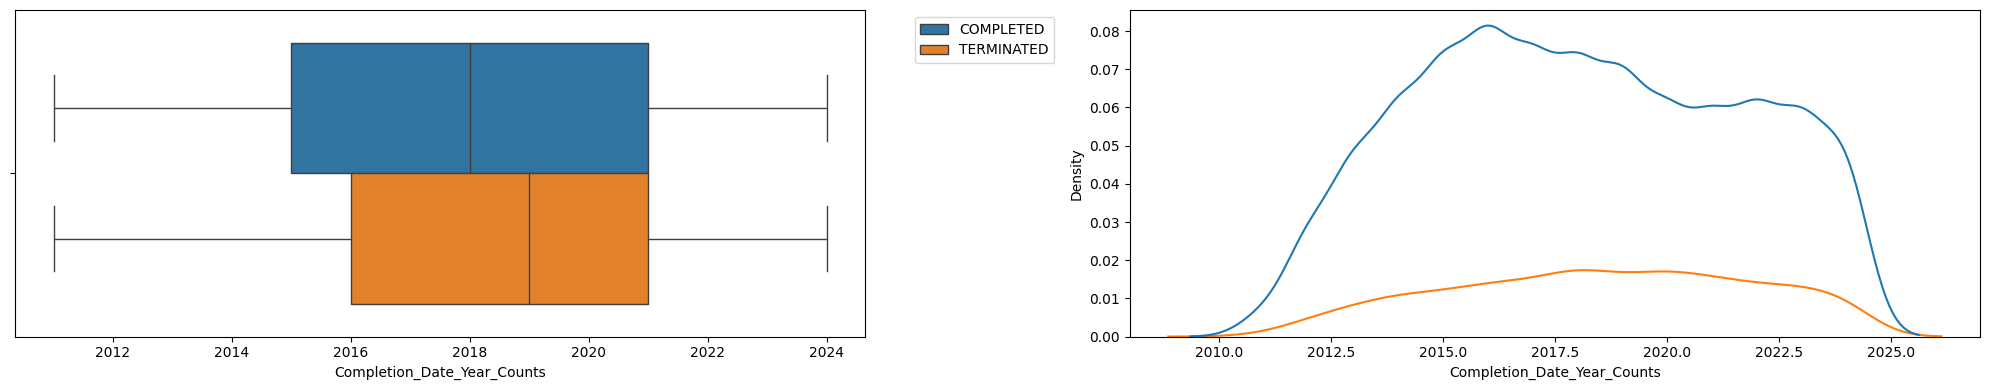

In [772]:
Completion_Date_Year_Counts = log_fun_cont("Completion_Date_Year_Counts", dfi, i)
# Plot is higher to completion as year pass --> Logic as trials of dataset are 2011-2024. 
# At 2011 that all started no trial was finished.

### Completion_Date_Year_Categ
- Categorization is covid dates oriented

df4-Phase4:
Completion_Date_Year_Categ vs Study Status

p-value: 8.54238159053384e-08 < 0.05

------------------------------------------------------------------------------------------------------------

df4-Phase4:
Completion_Date_Year_Categ vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Completion_Date_Year_Categ,,
2011-2018,6052,1136
2019-2024,4885,1173


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.002353
Time:                        05:28:58   Log-Likelihood:                -6114.0
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 7.880e-08
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.6729      0.032    -51.737      0.000      -1.736      -1.609
Completion_Date_Year_Categ     0.2463      0.046      5.371      0.000       0.156 

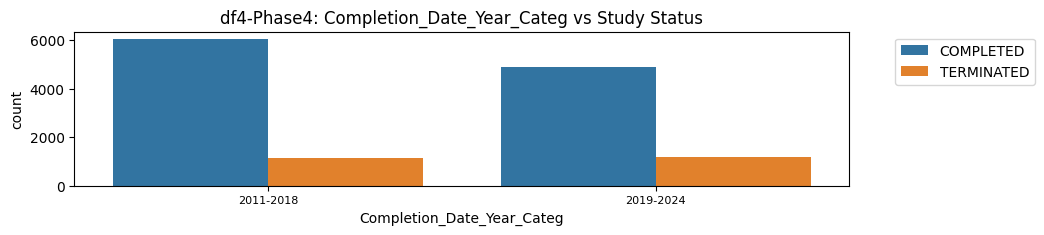

In [773]:
chi2_fun("Completion_Date_Year_Categ", dfi, i)
### log_fun
Completion_Date_Year_Categ = log_fun("Completion_Date_Year_Categ", dfi, i, 'bin', True, 0)

#### Drop

In [774]:
dfi = dfi.drop(columns = ['Start_Date_Year_Counts', 'Start_Date_Year_Categ', 
                         'Completion_Date_Year_Counts', 'Completion_Date_Year_Categ'], axis = 1)

### Completion_Gap_Counts

- Notice Termination main Distribution median = Around 20 participants --> cutpoint

df4-Phase4:
Completion_Gap_Counts vs Study Status


count      13246.0
mean     25.543334
std      20.092806
min            0.0
25%           11.0
50%           21.0
75%           35.0
max          149.0
Name: Completion_Gap_Counts, dtype: Float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:               4.838e-05
Time:                        05:28:58   Log-Likelihood:                -6128.2
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                    0.4413
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------

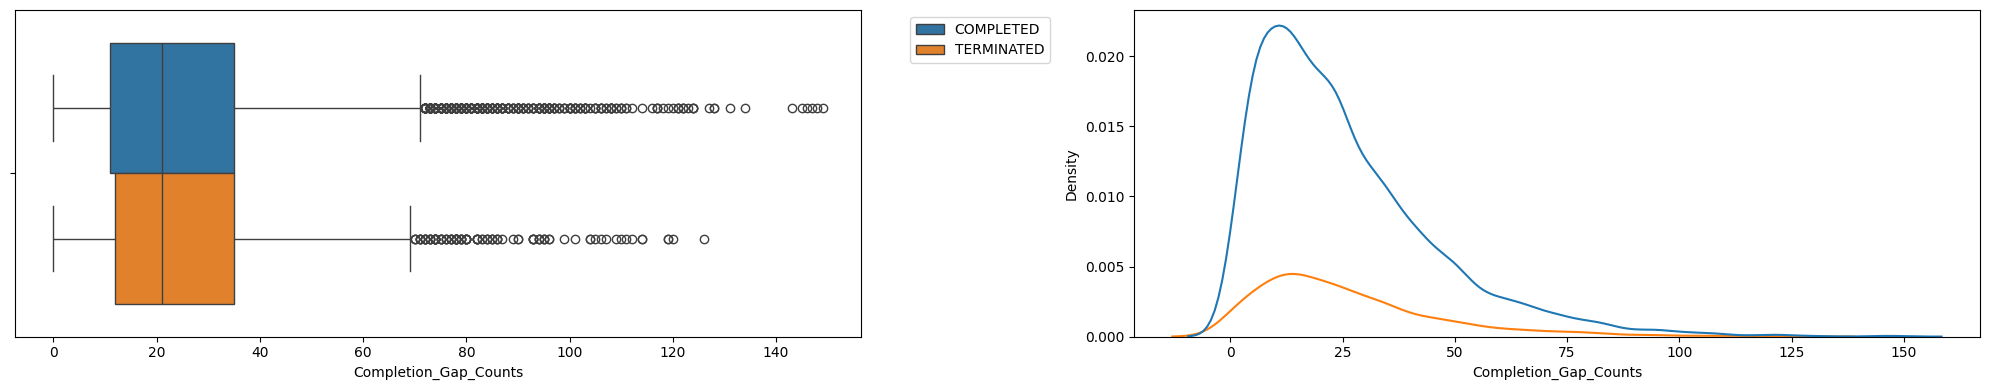

In [775]:
Completion_Gap_Counts = log_fun_cont("Completion_Gap_Counts", dfi, i)

### Completion_Gap_Log

df4-Phase4:
Completion_Gap_Log vs Study Status


count     13246.0
mean      2.96376
std      0.880658
min           0.0
25%      2.484907
50%      3.091042
75%      3.583519
max      5.010635
Name: Completion_Gap_Log, dtype: Float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:               6.361e-05
Time:                        05:28:59   Log-Likelihood:                -6128.1
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                    0.3772
                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

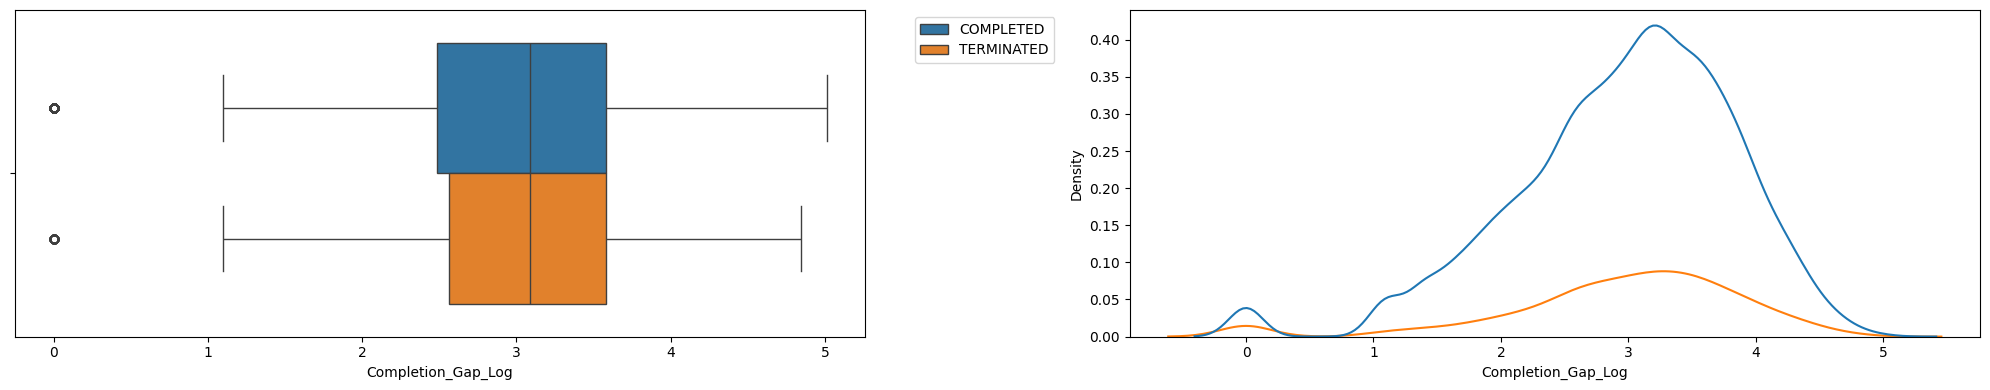

In [776]:
Completion_Gap_Log = log_fun_cont("Completion_Gap_Log", dfi, i)

### Completion_Gap_Categ

df4-Phase4:
Completion_Gap_Categ vs Study Status

p-value: 0.5487836685734989 > 0.05 - No significant difference

------------------------------------------------------------------------------------------------------------

df4-Phase4:
Completion_Gap_Categ vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Completion_Gap_Categ,,
0–21,5653,1177
22–149,5284,1132


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:               3.161e-05
Time:                        05:29:00   Log-Likelihood:                -6128.3
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                    0.5336
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.5692      0.032    -48.978      0.000      -1.632      -1.506
Completion_Gap_Categ     0.0285      0.046      0.622      0.534      -0.061       0.118


df4-Phase4

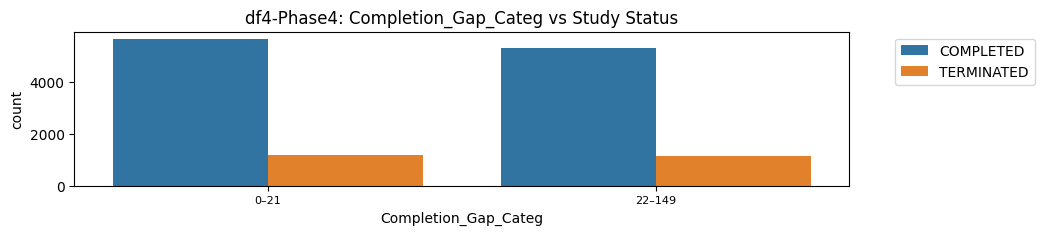

In [777]:
chi2_fun('Completion_Gap_Categ', dfi, i)
#### log_fun
Completion_Gap_Categ = log_fun('Completion_Gap_Categ', dfi, i, 'bin', True, 0)

#### Format

In [778]:
dfi = dfi.drop(columns = ['Completion_Gap_Counts', 'Completion_Gap_Categ'], axis=1)

## Enrollment

### Enrollment_Counts

df4-Phase4:
Enrollment_Counts vs Study Status


count     13246.000000
mean        470.627737
std        9615.979740
min           0.000000
25%          25.000000
50%          60.500000
75%         140.000000
max      864493.000000
Name: Enrollment_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                0.004392
Time:                        05:29:00   Log-Likelihood:                -6101.6
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                 2.190e-13
                        coef    std err          z      P>|z|      [0.025      0.975]
--------

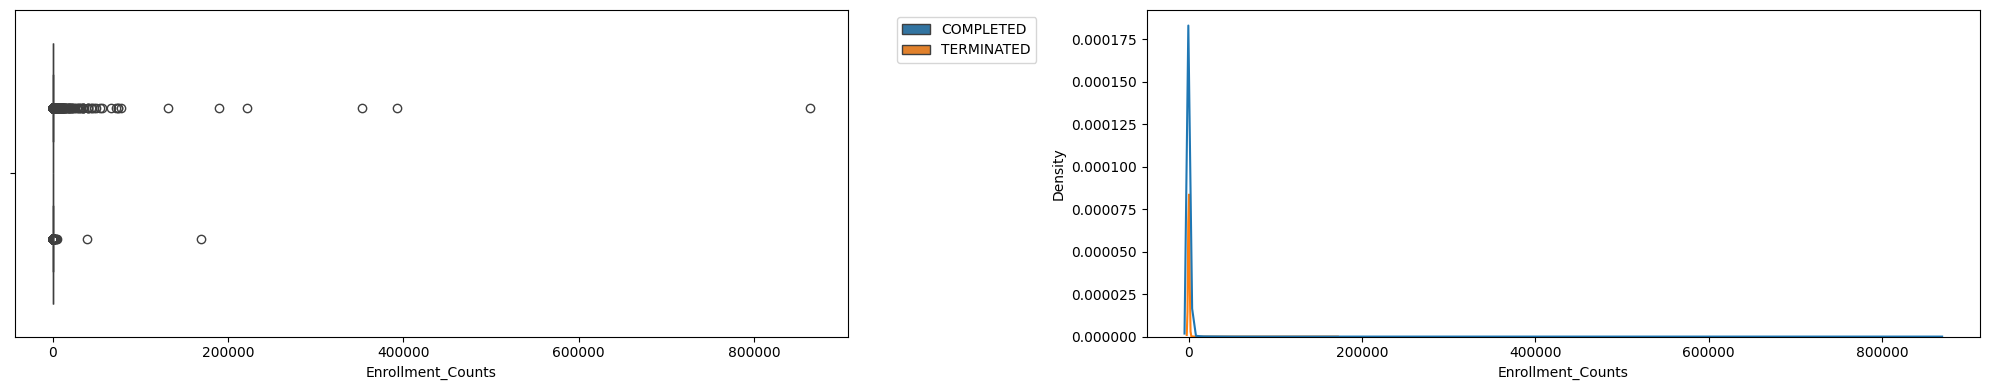

In [779]:
Enrollment_Counts = log_fun_cont("Enrollment_Counts", dfi, i)

Text(0.5, 0.98, 'Enrollment_Counts Scatterplots by Phase')

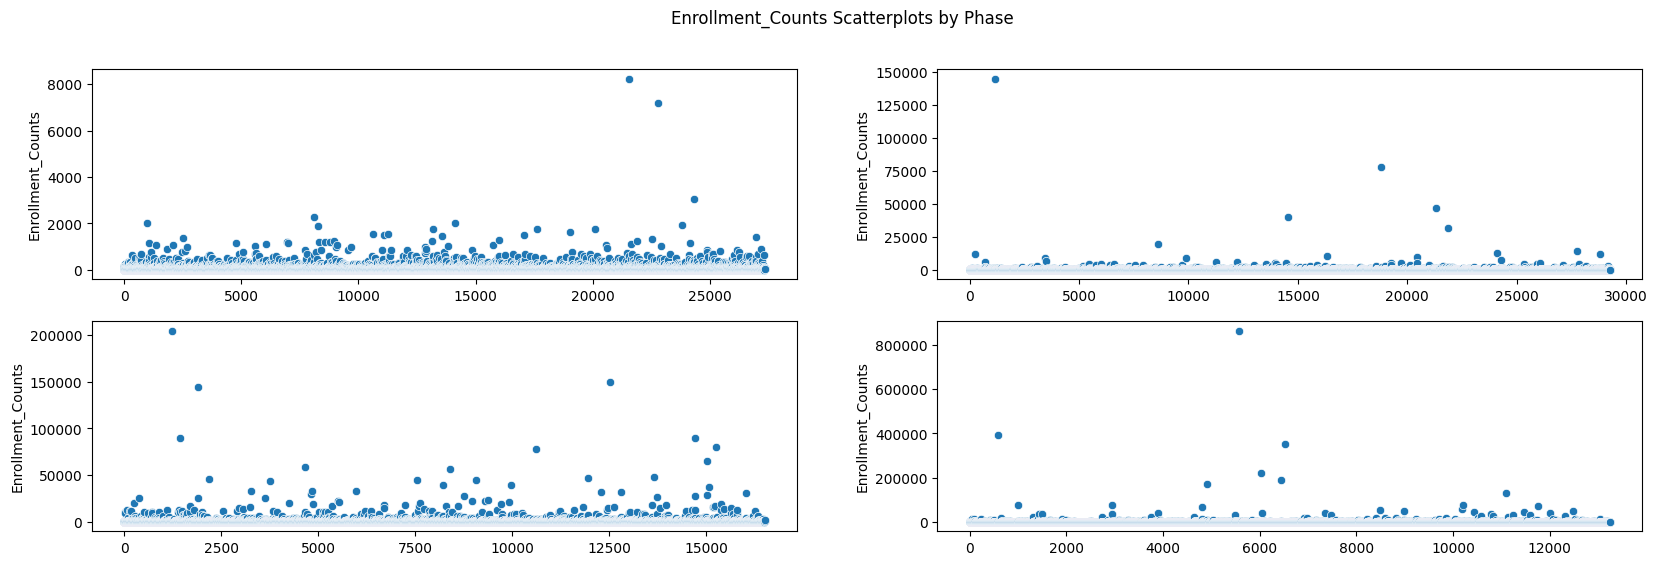

In [780]:
plt.fig, ax = plt.subplots(figsize=(20, 6), nrows = 2, ncols = 2)

sns.scatterplot(df1['Enrollment_Counts'], ax=ax[0,0])
sns.scatterplot(df2['Enrollment_Counts'], ax=ax[0,1])
sns.scatterplot(df3['Enrollment_Counts'], ax=ax[1,0])
sns.scatterplot(df4['Enrollment_Counts'], ax=ax[1,1])

plt.fig.suptitle('Enrollment_Counts Scatterplots by Phase')

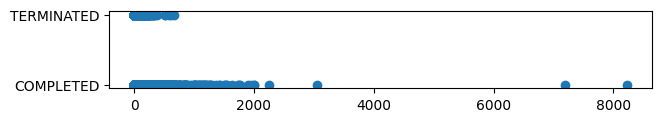

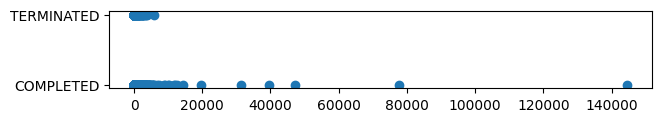

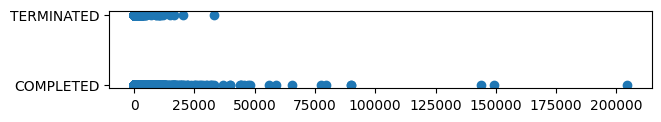

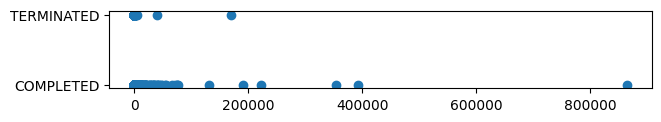

In [781]:
plt.figure(figsize=(7,1))
plt.scatter(df1['Enrollment_Counts'], df1['Study_Status_Bin'])
plt.figure(figsize=(7,1))
plt.scatter(df2['Enrollment_Counts'], df2['Study_Status_Bin'])
plt.figure(figsize=(7,1))
plt.scatter(df3['Enrollment_Counts'], df3['Study_Status_Bin'])
plt.figure(figsize=(7,1))
plt.scatter(df4['Enrollment_Counts'], df4['Study_Status_Bin'])

### Enrollment_Counts_Log

df4-Phase4:
Enrollment_Counts_Log vs Study Status


count    13246.000000
mean         4.026305
std          1.675532
min          0.000000
25%          3.258097
50%          4.119004
75%          4.948760
max         13.669900
Name: Enrollment_Counts_Log, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                  0.3923
Time:                        05:29:02   Log-Likelihood:                -3724.3
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
----

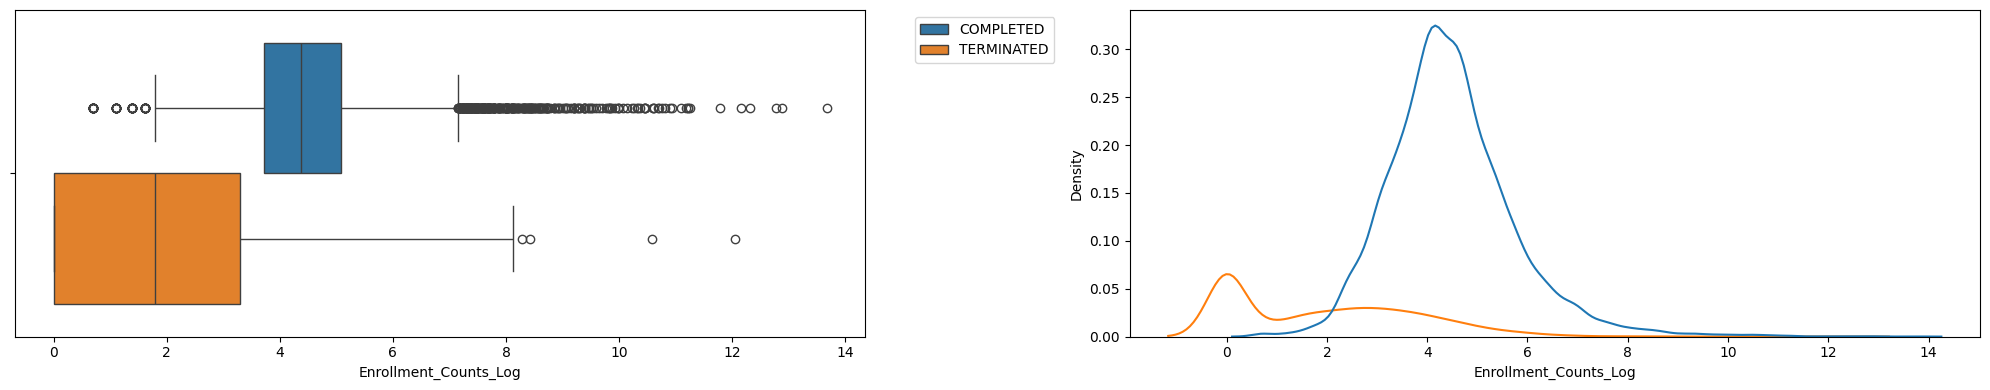

In [782]:
Enrollment_Counts_Log = log_fun_cont("Enrollment_Counts_Log", dfi, i)

Text(0.5, 0.98, 'Enrollment_Counts_Log Scatterplots by Phase')

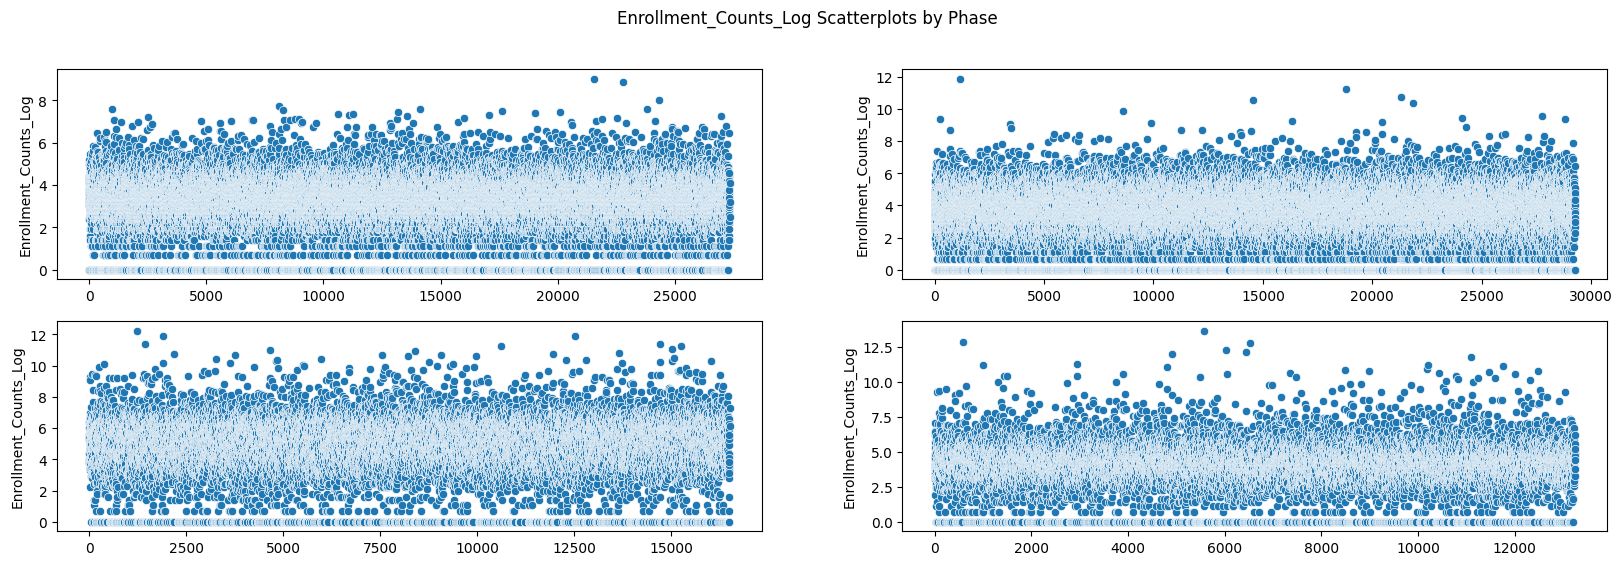

In [783]:
plt.fig, ax = plt.subplots(figsize=(20, 6), nrows = 2, ncols = 2)

sns.scatterplot(df1['Enrollment_Counts_Log'], ax=ax[0,0])
sns.scatterplot(df2['Enrollment_Counts_Log'], ax=ax[0,1])
sns.scatterplot(df3['Enrollment_Counts_Log'], ax=ax[1,0])
sns.scatterplot(df4['Enrollment_Counts_Log'], ax=ax[1,1])

plt.fig.suptitle('Enrollment_Counts_Log Scatterplots by Phase')

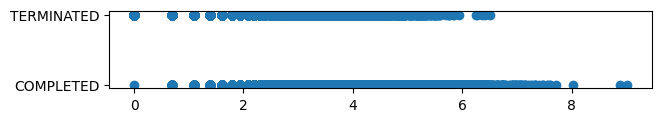

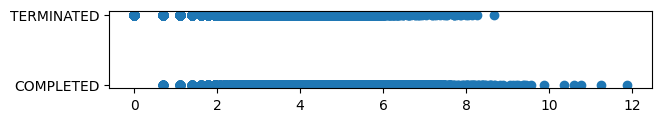

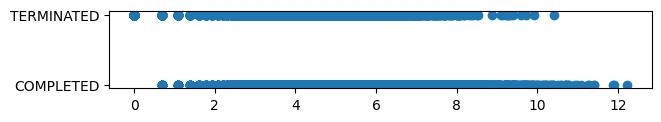

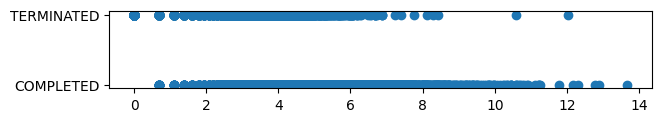

In [784]:
plt.figure(figsize=(7,1))
plt.scatter(df1['Enrollment_Counts_Log'], df1['Study_Status_Bin'])
plt.figure(figsize=(7,1))
plt.scatter(df2['Enrollment_Counts_Log'], df2['Study_Status_Bin'])
plt.figure(figsize=(7,1))
plt.scatter(df3['Enrollment_Counts_Log'], df3['Study_Status_Bin'])
plt.figure(figsize=(7,1))
plt.scatter(df4['Enrollment_Counts_Log'], df4['Study_Status_Bin'])

### Enrollment_Categ
- See Enrollment Plot as Continues below. Better Plot as continues (BoxPlot)

df4-Phase4:
Enrollment_Categ vs Study Status

p-value: 0.0 < 0.05

------------------------------------------------------------------------------------------------------------

df4-Phase4:
Enrollment_Categ vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Enrollment_Categ,,
0–60,4624,1999
61–864493,6313,310


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                13246
Model:                          Logit   Df Residuals:                    13244
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                  0.1339
Time:                        05:29:05   Log-Likelihood:                -5307.7
converged:                       True   LL-Null:                       -6128.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.8386      0.027    -31.329      0.000      -0.891      -0.786
Enrollment_Categ    -2.1752      0.064    -33.968      0.000      -2.301      -2.050


df4-Phase4: Enrollment_Cat

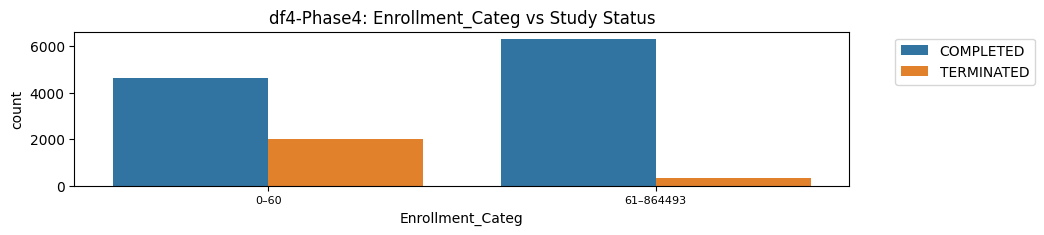

In [785]:
chi2_fun("Enrollment_Categ", dfi, i)
#### log_fun
Enrollment_Categ = log_fun('Enrollment_Categ', dfi, i, 'bin', True, 0)

#### Format

In [786]:
dfi = dfi.drop(columns = ['Enrollment_Counts', 'Enrollment_Categ'], axis = 1)

#### Enrollment Outliers

# P_Value/ CL : Univariable 

In [787]:
p_cols = dfi.columns.tolist()
# cls df
cl_vars = p_cols.copy()
cl_list = [globals()[var][2][1:] for var in cl_vars if var!= 'Study_Status_Bin']  
cls = pd.concat(cl_list, axis = 0).reset_index(drop = False)
cls = cls.rename(columns = {'index': f'Variable', 0: f'df{i}-Lower_CL', 1: f'df{i}-Upper_CL'})
cls[[f'df{i}-Lower_CL', f'df{i}-Upper_CL']] = cls[[f'df{i}-Lower_CL', f'df{i}-Upper_CL']].round(3)

# p_values df
p_vars = p_cols.copy()
p_list = [globals()[var][1][0][1:] for var in p_vars if var!= 'Study_Status_Bin']   
# [1][0][1:] Explain:
# [1] --> index = 1 of function's returns = p_value , 
# [0] --> gives back the unique element of list as a df, 
# [1:] --> excludes 1st row which is the constant.
p_values = pd.concat(p_list, axis = 0).reset_index(drop = False)
p_values = p_values.rename(columns = {'index': f'Variable', 0: f'df{i}-p-value'})
p_values[f'df{i}-p-value'] = p_values[f'df{i}-p-value'].round(3)

# p_cl df
p_cl = pd.merge(left = p_values, right = cls, how = 'inner', on = f'Variable')
p_cl[f'df{i}-Stat_Sig'] = np.where(
    # (((cls[f'df{i}-Lower_CL'] < 0.0) & (cls[f'df{i}-Upper_CL'] < 0.0)) |\
    # ((cls[f'df{i}-Lower_CL'] > 0.0) & (cls[f'df{i}-Upper_CL'] > 0.0))) &
     (p_cl[f'df{i}-p-value'] < 0.05), 
     'Stat_Sig', '-'
)
p_cl.index.name = f'df{i}'
p_cl = p_cl.drop_duplicates()
p_cl

,Variable,df4-p-value,df4-Lower_CL,df4-Upper_CL,df4-Stat_Sig
df4,,,,,
0,FEMALE,0.372,-0.208,0.078,-
1,MALE,0.011,-0.689,-0.088,Stat_Sig
2,ADULT,0.342,-0.288,0.100,-
3,OLDER_ADULT,0.000,0.346,0.601,Stat_Sig
4,Funder_Industry_Bin,0.001,-0.327,-0.087,Stat_Sig
...,...,...,...,...,...
112,South America,0.000,-1.095,-0.471,Stat_Sig
113,City_Counts_Log,0.000,-0.242,-0.136,Stat_Sig
114,Enrollment_Counts_Log,0.000,-2.150,-1.985,Stat_Sig


In [788]:
dfi.columns.to_list()

['Study_Status_Bin',
 'Sex_List',
 'Age_List',
 'Funder_Industry_Bin',
 'Completion_Gap_Log',
 'Intervention_Type_List',
 'Intervention_Route_List',
 'Placebo_Bin',
 'Standard_Care_Bin',
 'Healthy_Bin',
 'Covid_19_Bin',
 'Conditions_Detail_List',
 'Adverse_List',
 'Adverse_Counts_Log',
 'Adverse_Bin',
 'Adverse_System_List',
 'Adverse_System_Counts_Log',
 'Allocation_List',
 'Intervention_Model_List',
 'Masking_List',
 'Masking_Detail_List',
 'Primary_Purpose_List',
 'Arm_Counts_Log',
 'Countries_Counts_Log',
 'Continents_List',
 'City_Counts_Log',
 'Enrollment_Counts_Log',
 'Intervention_Type_Categ',
 'Intervention_Route_Categ']

# Save p_values

In [789]:
def save_pvalue_pickle(p_cl, i):
    
    if i == 1:
        path = r".\p_values\p_cl1_vizual.pkl"
    elif i == 2:
        path = r".\p_values\p_cl2_vizual.pkl"
    elif i == 3:
        path = r".\p_values\p_cl3_vizual.pkl"
    elif i == 4:
        path = r".\p_values\p_cl4_vizual.pkl"

    return p_cl.to_pickle(path)

save_pvalue_pickle(p_cl, i)


# Save Dfis
- Changes applied in drop columns

In [790]:
def save_df_pickle(dfi, i):
    
    if i == 1:
        path = r".\df_vizual\df1_vizual.pkl"
    elif i == 2:
        path = r".\df_vizual\df2_vizual.pkl"
    elif i == 3:
        path = r".\df_vizual\df3_vizual.pkl"
    elif i == 4:
        path = r".\df_vizual\df4_vizual.pkl"

    return dfi.to_pickle(path)

save_df_pickle(dfi, i)